# Classifying Emotions from Text

In [1]:
!pip install -q evaluate
!pip install --upgrade transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 53.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 558.8/558.8 kB 30.0 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.33.4
    Uninstalling huggingface-hub-0.33.4:
      Successfully uninstalled huggingface-hub-0.33.4
  Attempting uninstall: transformers
    Found existing installation: transformers 4.53.3
    Uninstalling transformers-4.53.3:
      Successfully uninstalled transformers-4.53.3


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import evaluate
from datasets import Dataset
from sklearn.metrics import confusion_matrix, classification_report


import transformers
from transformers import EarlyStoppingCallback
import evaluate
import torch
import torch.nn as nn
from transformers import RobertaTokenizer, RobertaPreTrainedModel, RobertaModel
from transformers import AutoTokenizer, BertForSequenceClassification, BertTokenizer, RobertaTokenizer, RobertaForSequenceClassification
from transformers import TrainingArguments, Trainer
import torch
from tqdm import tqdm

Pull Data

In [ ]:
!wget -P data/full_dataset/ https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_1.csv
!wget -P data/full_dataset/ https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_2.csv
!wget -P data/full_dataset/ https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_3.csv

df1 = pd.read_csv("data/full_dataset/goemotions_1.csv")
df2 = pd.read_csv("data/full_dataset/goemotions_2.csv")
df3 = pd.read_csv("data/full_dataset/goemotions_3.csv")
emotions = pd.concat([df1, df2, df3], ignore_index = True)
emotions.head()

--2025-07-25 03:36:23--  https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_1.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.118.207, 172.217.194.207, 142.251.10.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.118.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14174600 (14M) [application/octet-stream]
Saving to: ‘data/full_dataset/goemotions_1.csv’

goemotions_1.csv    100%[===================>]  13.52M  7.30MB/s    in 1.9s    

2025-07-25 03:36:25 (7.30 MB/s) - ‘data/full_dataset/goemotions_1.csv’ saved [14174600/14174600]

--2025-07-25 03:36:25--  https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_2.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.118.207, 172.217.194.207, 142.251.10.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.118.207|:443... connected.
HTTP request sent, awaiting

,text,id,author,subreddit,link_id,parent_id,created_utc,rater_id,example_very_unclear,admiration,...,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
0,That game hurt.,eew5j0j,Brdd9,nrl,t3_ajis4z,t1_eew18eq,1.548381e+09,1,False,0,...,0,0,0,0,0,0,0,1,0,0
1,>sexuality shouldn’t be a grouping category I...,eemcysk,TheGreen888,unpopularopinion,t3_ai4q37,t3_ai4q37,1.548084e+09,37,True,0,...,0,0,0,0,0,0,0,0,0,0
2,"You do right, if you don't care then fuck 'em!",ed2mah1,Labalool,confessions,t3_abru74,t1_ed2m7g7,1.546428e+09,37,False,0,...,0,0,0,0,0,0,0,0,0,1
3,Man I love reddit.,eeibobj,MrsRobertshaw,facepalm,t3_ahulml,t3_ahulml,1.547965e+09,18,False,0,...,1,0,0,0,0,0,0,0,0,0
4,"[NAME] was nowhere near them, he was by the Fa...",eda6yn6,American_Fascist713,starwarsspeculation,t3_ackt2f,t1_eda65q2,1.546669e+09,2,False,0,...,0,0,0,0,0,0,0,0,0,1


Dataset shape: (211225, 37)
Index(['text', 'id', 'author', 'subreddit', 'link_id', 'parent_id',
       'created_utc', 'rater_id', 'example_very_unclear', 'admiration',
       'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion',
       'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust',
       'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy',
       'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief',
       'remorse', 'sadness', 'surprise', 'neutral'],
      dtype='object')
                                                text       id  \
0                                    That game hurt.  eew5j0j   
1   >sexuality shouldn’t be a grouping category I...  eemcysk   
2     You do right, if you don't care then fuck 'em!  ed2mah1   
3                                 Man I love reddit.  eeibobj   
4  [NAME] was nowhere near them, he was by the Fa...  eda6yn6   

                author            subreddit    link_id   parent_

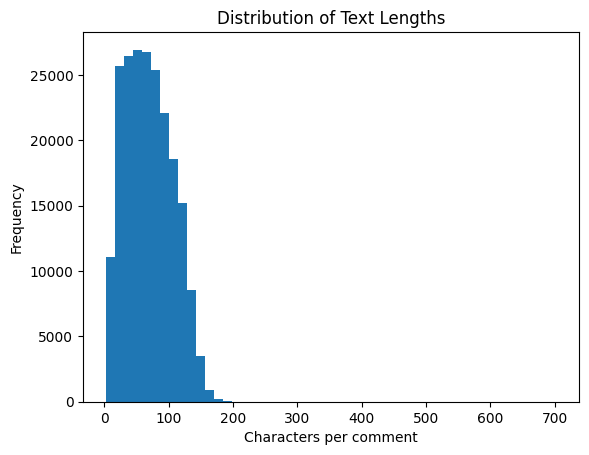

In [ ]:
# Check shape and columns
print(f"Dataset shape: {emotions.shape}")
print(emotions.columns)

# Inspect the first few rows
print(emotions.head())

# Check for missing values
print(emotions.isnull().sum())

# Distribution of text lengths (number of tokens or characters)
emotions['text_length'] = emotions['text'].apply(len)
plt.hist(emotions['text_length'], bins=50)
plt.title("Distribution of Text Lengths")
plt.xlabel("Characters per comment")
plt.ylabel("Frequency")
plt.show()

### Data Cleaning
* A text can have more than one row with only one flag for the list of emtion.   
* Making sure we have distinct rows of text where there can be more than one emotion flagged per row
* Removing rows that have no labels

In [ ]:
# Columns to drop
drop_cols = ['id', 'author', 'subreddit', 'link_id', 'parent_id', 'created_utc', 'rater_id','example_very_unclear']

# Find columns that exist in the DataFrame
existing_cols_to_drop = [col for col in drop_cols if col in emotions.columns]

emotions.drop(existing_cols_to_drop, axis = 1, inplace = True)

# shape of data
print("SHAPE BEFORE MULTI-LABELS")
print("Shape of Emotions Dataset", emotions.shape)
print("Number of Unique Texts", emotions[['text','text_length']].nunique())

# Grouping by text and aggregated emtion flags
label_cols = emotions.columns.difference(['text','text_length'])
emotions_multi = emotions.groupby('text')[label_cols].max().reset_index()

print("\nSHAPE AFTER MULTI-LABELS")
print("Shape of Emotions Dataset", emotions_multi.shape)
print("Number of Unique Texts", emotions_multi['text'].nunique())

SHAPE BEFORE MULTI-LABELS
Shape of Emotions Dataset (211225, 30)
Number of Unique Texts text           57732
text_length      192
dtype: int64

SHAPE AFTER MULTI-LABELS
Shape of Emotions Dataset (57732, 29)
Number of Unique Texts 57732


In [ ]:
emotions_multi.head()

,text,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,desire,...,love,nervousness,neutral,optimism,pride,realization,relief,remorse,sadness,surprise
0,"""If you don't wear BROWN AND ORANGE...YOU DON...",0,0,1,1,1,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0
1,"""What do Scottish people look like?"" How I wo...",0,0,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
2,"### A surprise, to be sure, but a welcome one",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,"'*Pray*, v. To ask that the laws of the unive...",0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,">it'll get invaded by tankie, unfortunately. ...",0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [ ]:
# Removing rows that have no labels
emotions_multi = emotions_multi[emotions_multi[label_cols].any(axis=1)]
print("Shape of Emotions Dataset", emotions_multi.shape)

Shape of Emotions Dataset (57730, 29)


### Spliting data into Train, Test, and Validation

* **60% - Train:** Used to train the model and update its weights   
* **20% - Validation:** Used to tune hyperparameters (like learning rate, batch size, epochs) and monitor for overfitting.
* **20% - Test:** Evaluate final model's performance on unseen data after all tuning is done

In [ ]:
# Creating relevant columns for labels
# Y value
label_cols = emotions.columns.difference(['text','text_length'])

# Splitting Train, Test, Validation
x_train, x_temp, y_train, y_temp = train_test_split(emotions_multi['text'], emotions_multi[label_cols], test_size = 0.4, random_state = 42)
x_test, x_val, y_test, y_val = train_test_split(x_temp, y_temp, test_size = 0.5, random_state = 42)

# Combine features and labels into one dataframe for each split
train_emotions = pd.concat([x_train.reset_index(drop=True), y_train.reset_index(drop=True)], axis=1)
val_emotions   = pd.concat([x_val.reset_index(drop=True),   y_val.reset_index(drop=True)],   axis=1)
test_emotions  = pd.concat([x_test.reset_index(drop=True),  y_test.reset_index(drop=True)],  axis=1)

# Convert the DataFrames into Hugging Face Datasets
train_dataset = Dataset.from_pandas(train_emotions)
val_dataset = Dataset.from_pandas(val_emotions)
test_dataset = Dataset.from_pandas(test_emotions)


## Exploratory Data Analysis

Continuing to use train dataset for data exploration

**Simran Exploration Takeaways:**
* There is some class imbalance when it comes to labels, many text are labeled as neutral. Which makes sense since many text can just be regular comments that don't always need to express emtions.
* Many text have 2 emotions labels

In [ ]:
print("Shape of Emotions Dataset", emotions_multi.shape)
print("Shape of Train Dataset", x_train.shape, y_train.shape)
print("Shape of Test Dataset", x_test.shape, y_test.shape)
print("Shape of Validation Dataset", x_val.shape, y_val.shape)

Shape of Emotions Dataset (57730, 29)
Shape of Train Dataset (34638,) (34638, 28)
Shape of Test Dataset (11546,) (11546, 28)
Shape of Validation Dataset (11546,) (11546, 28)


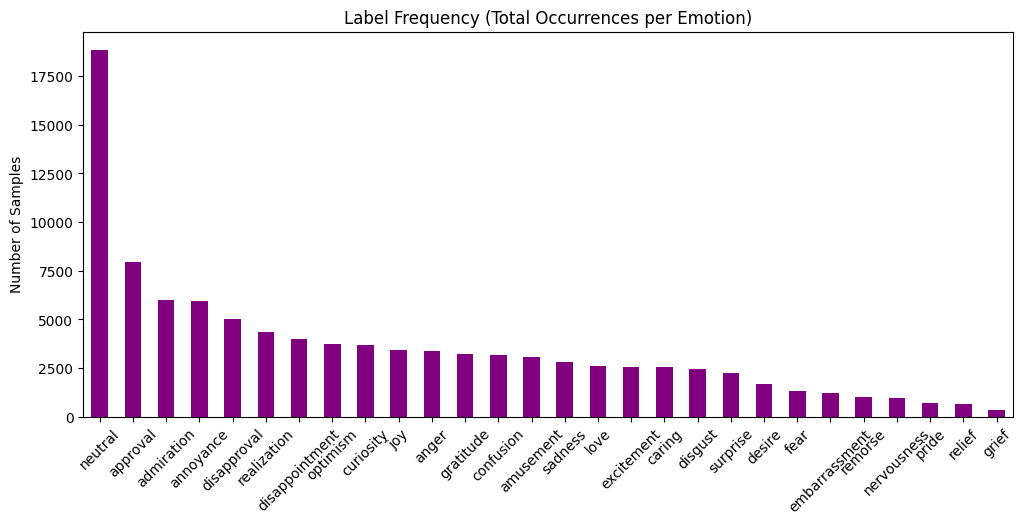

In [ ]:
# Exploring label frequency - seeing which emotions are more common across all text

label_counts = y_train.sum().sort_values(ascending=False)

plt.figure(figsize=(12,5))
label_counts.plot(kind='bar', color='purple')
plt.title("Label Frequency (Total Occurrences per Emotion)")
plt.ylabel("Number of Samples")
plt.xticks(rotation=45)
plt.show()

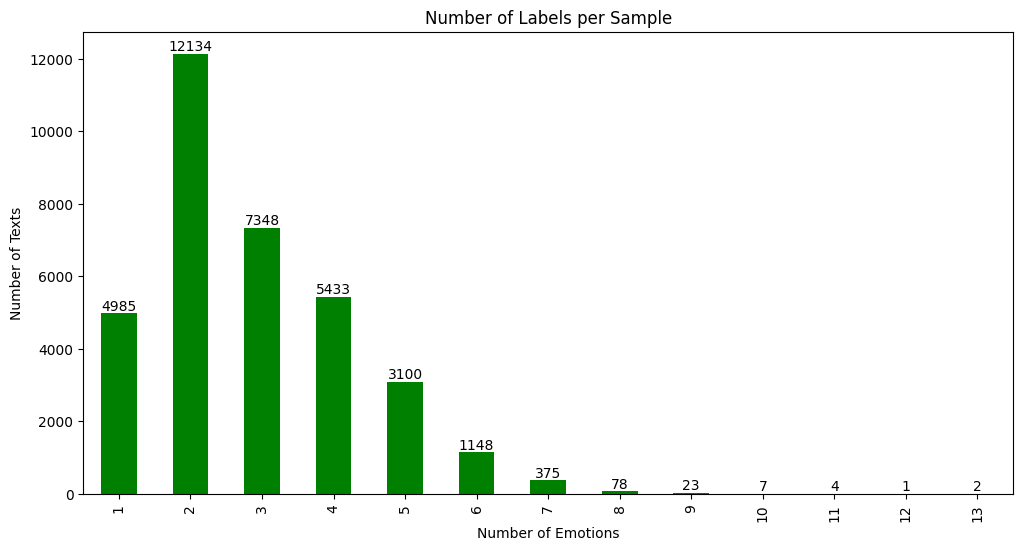

count    34638.000000
mean         2.858854
std          1.413529
min          1.000000
25%          2.000000
50%          3.000000
75%          4.000000
max         13.000000
dtype: float64


In [ ]:
# Seeing number of labels a typical text has

num_labels_per_sample = y_train.sum(axis=1)
counts = num_labels_per_sample.value_counts().sort_index()

# Plot the bar chart
plt.figure(figsize=(12, 6))
counts.plot(kind='bar', color='green')
for i, count in enumerate(counts):
    plt.text(i, count + 0.05, str(count), ha='center', va='bottom', fontsize=10)
plt.title("Number of Labels per Sample")
plt.xlabel("Number of Emotions")
plt.ylabel("Number of Texts")
plt.show()

print(num_labels_per_sample.describe())


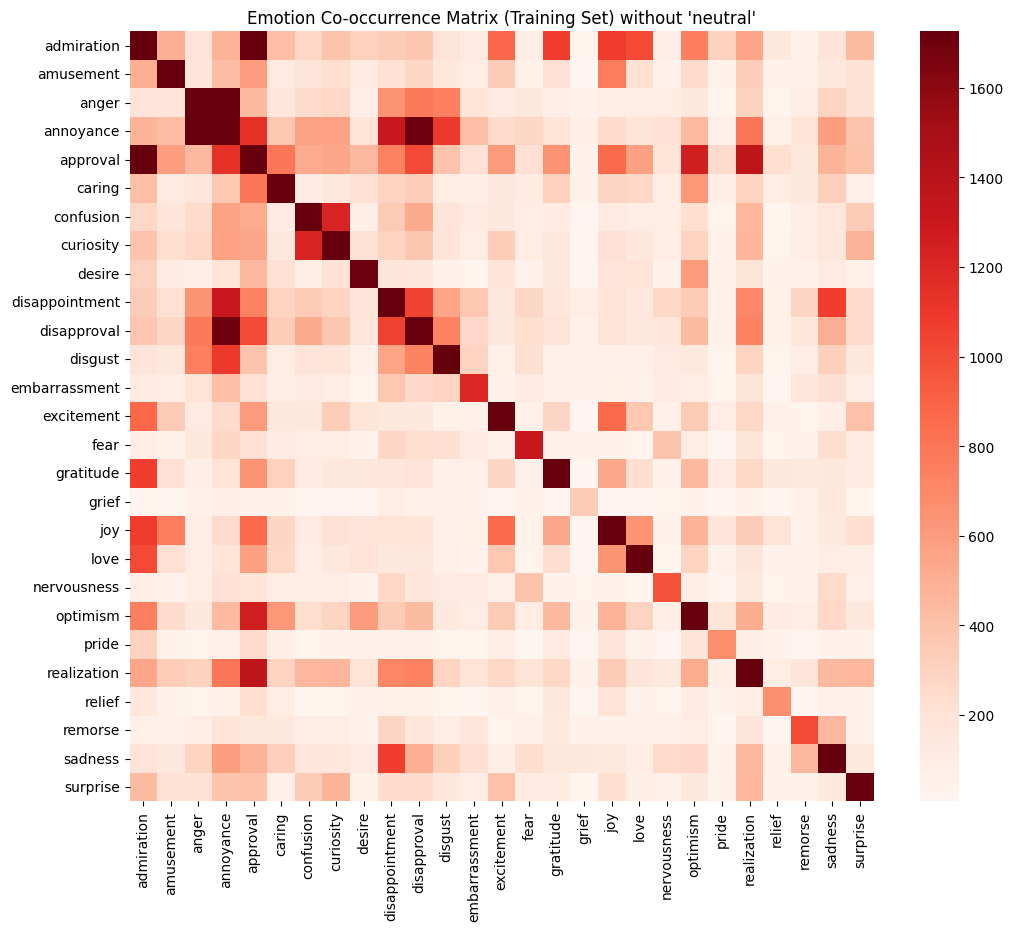

In [ ]:
# emotion co-occurence heatmap, remove "neutral" so it won't dominate the colors

import seaborn as sns

emotions_wo_neutral = y_train.columns.difference(['neutral'])
emotion_cooccur = y_train[emotions_wo_neutral].T.dot(y_train[emotions_wo_neutral])

plt.figure(figsize=(12, 10))
sns.heatmap(emotion_cooccur, cmap="Reds", xticklabels=True, yticklabels=True, vmax=emotion_cooccur.quantile(0.95).max())
plt.title("Emotion Co-occurrence Matrix (Training Set) without 'neutral'")
plt.show()


In [ ]:
# find top co-occurring pairs (excluding neutral)
top_pairs = emotion_cooccur.where(np.triu(np.ones(emotion_cooccur.shape), k=1).astype(bool))
top_pairs = top_pairs.stack().sort_values(ascending=False).reset_index().rename(columns ={'level_0':'emotion_1', 'level_1':'emotion_2',0:'co-orurrence'})

print(top_pairs.head(10))

    emotion_1       emotion_2  co-orurrence
0  admiration        approval        1785.0
1       anger       annoyance        1738.0
2   annoyance     disapproval        1698.0
3    approval     realization        1364.0
4   annoyance  disappointment        1307.0
5    approval        optimism        1260.0
6   confusion       curiosity        1224.0
7   annoyance        approval        1143.0
8   annoyance         disgust        1091.0
9  admiration             joy        1076.0


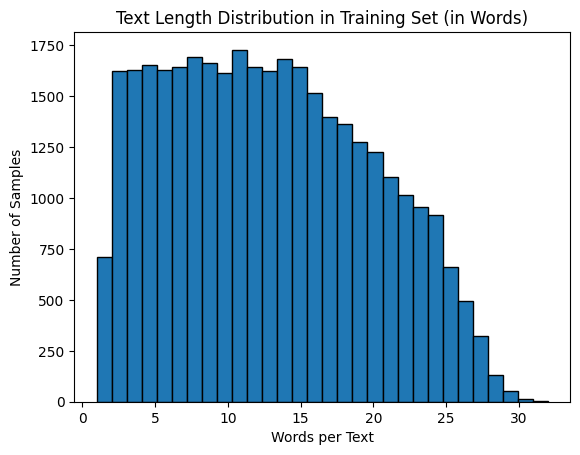

count    34638.000000
mean        12.984006
std          6.698078
min          1.000000
25%          7.000000
50%         13.000000
75%         18.000000
max         32.000000
Name: text, dtype: float64


In [ ]:
# Understaning the size of text inputs

# Calculate number of words per text
x_train_lengths = x_train.str.split().apply(len)

# Plot histogram of text lengths
x_train_lengths.plot(kind='hist', bins=30, edgecolor='black')
plt.title("Text Length Distribution in Training Set (in Words)")
plt.xlabel("Words per Text")
plt.ylabel("Number of Samples")
plt.show()

# Describe text length stats
print(x_train_lengths.describe())

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

count    34638.000000
mean        19.350424
std          8.679747
min          3.000000
50%         19.000000
90%         31.000000
95%         34.000000
99%         38.000000
max        316.000000
Name: text, dtype: float64


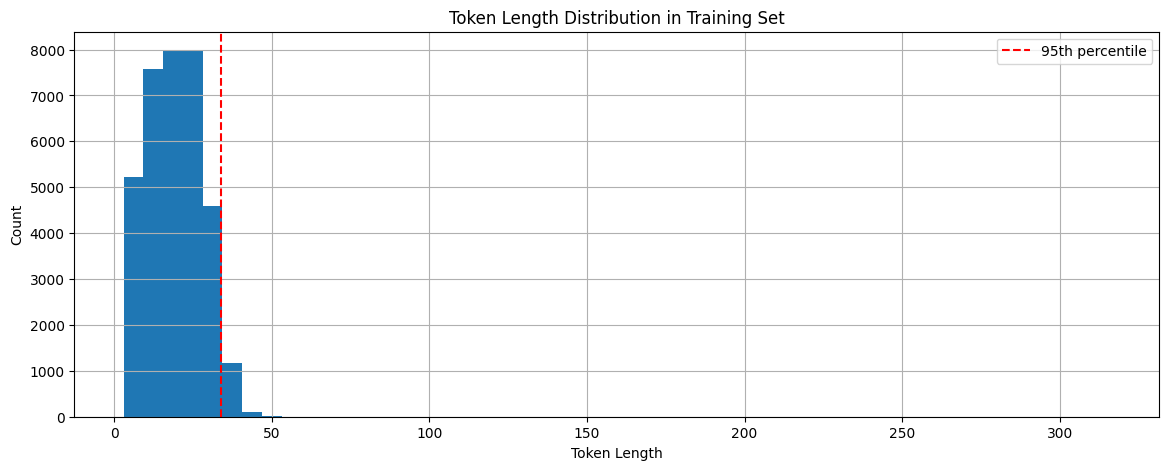

In [ ]:
# token length analysis - help to decide the max sequence length

from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
token_lengths = x_train.apply(lambda x: len(tokenizer.encode(x, truncation=False)))

# summary statistics
print(token_lengths.describe(percentiles=[0.9, 0.95, 0.99]))

plt.figure(figsize=(14, 5))
token_lengths.hist(bins=50)
plt.axvline(token_lengths.quantile(0.95), color='red', linestyle='dashed', label='95th percentile')
plt.title("Token Length Distribution in Training Set")
plt.xlabel("Token Length")
plt.ylabel("Count")
plt.legend()
plt.show()

# Testing the 4 different experiments using RoBERTa

| Experiment # | Name                             | Description                                                                 |
|--------------|----------------------------------|------------------------------------------------------------------------------|
| 1            | Simple Baseline                  | Creating a simple model without adding weights, thresholds, or freezing layers. |
| 2            | Simple Baseline plus Thresholds  | Optimize thresholds per label for F1 using baseline model                   |
| 3            | Weighted Loss                    | Adding class weights to handle imbalance                                    |
| 4            | Weighted + Threshold             | Combines class weights and threshold tuning (tuned using weighted model)    |
| 5            | Weighted + Threshold + Freezing Layers | Adds layer freezing to reduce overfitting and improve generalization   |



In [ ]:
MAX_SEQUENCE_LENGTH = 35

In [ ]:
label_cols = emotions.columns.difference(['text','text_length'])  # Skip the 'text' and 'text_length' column

# Preprocessing function that accepts both data and tokenizer
def preprocess_emotions(data, tokenizer):
    """
    Function tokenizes text and converts the emotion labels into a list of floats
    """
    encoded = tokenizer.batch_encode_plus(
        data["text"],
        max_length=MAX_SEQUENCE_LENGTH,
        padding="max_length",
        truncation=True,
        return_attention_mask=True,
        return_token_type_ids=False,
    )

    # Process multi-label binary targets
    encoded["labels"] = [
        [float(data[label][i]) for label in label_cols]
        for i in range(len(data["text"]))
    ]

    return encoded

###########################################################################
# Compute Metric Baseline
def compute_metrics(p):
    predictions, labels = p
    predictions = (predictions > 0.5).astype(int)

    # Calculate precision, recall, and F1 score
    subset_accuracy = accuracy_score(labels, predictions)
    precision = precision_score(labels, predictions, average='micro')
    recall = recall_score(labels, predictions, average='micro')
    f1 = f1_score(labels, predictions, average='micro')

    # Return all the metrics
    return {
        "subset_accuracy": subset_accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

###########################################################################

# Function to compute per-epoch metrics for each label
def compute_per_label_metrics(predictions, labels):
    label_metrics = {}
    for idx, label in enumerate(label_cols):
        precision = precision_score(labels[:, idx], predictions[:, idx], zero_division=0)
        recall = recall_score(labels[:, idx], predictions[:, idx], zero_division=0)
        f1 = f1_score(labels[:, idx], predictions[:, idx], zero_division=0)
        label_metrics[label] = {"precision": precision, "recall": recall, "f1": f1}
    return label_metrics


################################################################################
# Compute Metric Fine Tuned
def best_threshold_compute_metrics(p):
    global best_thresholds
    predictions, labels = p

    # Load the best thresholds if they exist
    try:
        best_thresholds = np.load("best_thresholds.npy")
    except FileNotFoundError:
        print("Best thresholds not found. Using default 0.5 thresholds.")
        best_thresholds = None

    # Apply sigmoid if not already applied
    predictions = torch.sigmoid(torch.tensor(predictions)).numpy()

    # Use optimized thresholds if available
    if best_thresholds is not None:
        binary_predictions = np.zeros_like(predictions)
        for i, thresh in enumerate(best_thresholds):
            binary_predictions[:, i] = (predictions[:, i] >= thresh).astype(int)
    else:
        binary_predictions = (predictions >= 0.5).astype(int)

    # Calculate metrics
    subset_accuracy = accuracy_score(labels, binary_predictions)
    precision = precision_score(labels, binary_predictions, average='micro')
    recall = recall_score(labels, binary_predictions, average='micro')
    f1 = f1_score(labels, binary_predictions, average='micro')

    return {
        "subset_accuracy": subset_accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }


##########################################################################
# Evaluation per Label
def label_evaluation(trainer, preprocessed_dev_data, metrics):

    # Final evaluation on validation set
    final_val_metrics = trainer.evaluate(preprocessed_dev_data)

    print("\nFinal Validation Per-Label Metrics:")
    per_label_metrics = {
        "Label": [],
        "Precision": [],
        "Recall": [],
        "F1": []
    }

    output = trainer.predict(preprocessed_dev_data)
    predictions = output.predictions
    labels = output.label_ids
    predictions = torch.sigmoid(torch.tensor(predictions)).numpy()

    if metrics == compute_metrics:
      binary_predictions = (predictions > 0.5).astype(int)
    else:
      if best_thresholds is not None:
          binary_predictions = np.zeros_like(predictions)
          for i, thresh in enumerate(best_thresholds):
              binary_predictions[:, i] = (predictions[:, i] >= thresh).astype(int)
      else:
          binary_predictions = (predictions >= 0.5).astype(int)

     # Compute metrics per label
    label_metrics = compute_per_label_metrics(binary_predictions, labels)


    for label, metrics in label_metrics.items():
        per_label_metrics["Label"].append(label)
        per_label_metrics["Precision"].append(metrics["precision"])
        per_label_metrics["Recall"].append(metrics["recall"])
        per_label_metrics["F1"].append(metrics["f1"])

    # Create a DataFrame for per-label metrics
    df = pd.DataFrame(per_label_metrics)
    print(df)

    return df


###########################################################################

# Use a wrapper function to pass the tokenizer to the preprocess function
def preprocess_with_tokenizer(batch, tokenizer):
    return preprocess_emotions(batch, tokenizer)

###########################################################################

def fine_tune_classification_model(classification_model,
                                   tokenizer,
                                   train_data,
                                   dev_data,
                                   training_arguments=None,
                                   batch_size=16,
                                   num_epochs=2,
                                   metrics= compute_metrics):
    """
    Preprocess the data using the given tokenizer.
    Create the training arguments and trainer for the given model and data.
    Then train it.
    """
    # Preprocess the data
    preprocessed_train_data = train_data.map(preprocess_with_tokenizer, batched=True, fn_kwargs={'tokenizer': tokenizer})
    preprocessed_dev_data = dev_data.map(preprocess_with_tokenizer, batched=True, fn_kwargs={'tokenizer': tokenizer})

    # Set the training arguments if not provided
    if training_arguments is None:
        training_args = TrainingArguments(
            output_dir="emotions_model",
            per_device_train_batch_size=batch_size,
            per_device_eval_batch_size=batch_size,
            num_train_epochs=num_epochs,
            eval_strategy="epoch",
            save_strategy="epoch",
            report_to='none'
        )
    else:
        training_args = training_arguments

    # Set up the trainer
    trainer = Trainer(
        model=classification_model,
        args=training_args,
        train_dataset=preprocessed_train_data,
        eval_dataset=preprocessed_dev_data,
        tokenizer=tokenizer,
        compute_metrics=metrics
    )

    # Train the model
    trainer.train()

    label_eval = label_evaluation(trainer, preprocessed_dev_data, metrics)


    return trainer, preprocessed_dev_data, label_eval

###########################################################################


# def fine_tune_classif_model_freeze_layers(classification_model,
#                                           tokenizer,
#                                           train_data,
#                                           dev_data,
#                                           layers_to_train=["classifier."],
#                                           max_sequence_length=MAX_SEQUENCE_LENGTH,
#                                           batch_size=16,
#                                           num_epochs=2,
#                                           metrics=compute_metrics):
#     """
#     Fine-tune a classification model while freezing all layers except those specified
#     in layers_to_train (partial substring match on parameter names).
#     """

#     # Preprocess the datasets with the tokenizer
#     preprocessed_train_data = train_data.map(
#         preprocess_with_tokenizer,
#         batched=True,
#         fn_kwargs={'tokenizer': tokenizer}
#     )
#     preprocessed_dev_data = dev_data.map(
#         preprocess_with_tokenizer,
#         batched=True,
#         fn_kwargs={'tokenizer': tokenizer}
#     )

#     # Freeze all layers except those matching substrings in layers_to_train
#     for name, param in classification_model.named_parameters():
#       if not any(layer_name in name for layer_name in layers_to_train):
#         param.requires_grad = False

#     # Define training arguments
#     training_args = TrainingArguments(
#         output_dir="bert_fine_tuned_freeze_emotions",
#         per_device_train_batch_size=batch_size,
#         per_device_eval_batch_size=batch_size,
#         num_train_epochs=num_epochs,
#         eval_strategy="epoch",
#         save_strategy="epoch",
#         report_to='none'
#     )

#     # Define Trainer
#     trainer = Trainer(
#         model=classification_model,
#         args=training_args,
#         train_dataset=preprocessed_train_data,
#         eval_dataset=preprocessed_dev_data,
#         compute_metrics=metrics
#     )
#     # Train the model
#     trainer.train()

#     label_eval = label_evaluation(trainer, preprocessed_dev_data, metrics)

#     return trainer, preprocessed_dev_data, label_eval

# ###########################################################################


# def calc_label_metrics(label, y_true, y_pred, threshold):
#     return {
#         "label": label,
#         "threshold": threshold,
#         "f1": f1_score(y_true, y_pred, zero_division=0),
#     }

# def optimize_thresholds_verbose(predictions, labels, label_names):
#     threshold_results = {}
#     for t in tqdm(range(5, 100, 5), desc="Optimizing thresholds"):
#         threshold = t / 100
#         y_preds_all = (predictions > threshold).astype(int)
#         threshold_results[threshold] = []
#         for label_index, label in enumerate(label_names):
#             y_true = labels[:, label_index]
#             y_pred = y_preds_all[:, label_index]
#             threshold_results[threshold].append(
#                 calc_label_metrics(label, y_true, y_pred, threshold)
#             )

#     # Find best threshold per label
#     best = {label: {"f1": -1, "result": None} for label in label_names}
#     for threshold, results in threshold_results.items():
#         for result in results:
#             label = result["label"]
#             if result["f1"] > best[label]["f1"]:
#                 best[label] = {
#                     "f1": result["f1"],
#                     "result": result,
#                 }

#     # Create DataFrame
#     results = [b["result"] for b in best.values()]
#     df = pd.DataFrame(results, index=[r["label"] for r in results])

#     # Save best thresholds for future use
#     np.save("best_thresholds.npy", df["threshold"].values)

    return df


_______________________________________________________________________________________________
# RoBERTa Model

In [ ]:
label_frequencies = emotions[label_cols].mean().values
class_weights = 1.0 / (label_frequencies + 1e-5)  # Add epsilon to avoid division by zero
class_weights = torch.tensor(class_weights, dtype=torch.float)

# Define the custom Roberta model
class RobertaForMultiLabelClassification(RobertaPreTrainedModel):
    def __init__(self, config, class_weights=None):
        super().__init__(config)
        self.num_labels = config.num_labels
        self.class_weights = class_weights

        self.roberta = RobertaModel(config)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)

        self.init_weights()

    def forward(self, input_ids=None, attention_mask=None, labels=None):
        # Get outputs from the base model
        outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = self.dropout(outputs.last_hidden_state[:, 0, :])  # CLS token

        logits = self.classifier(pooled_output)

        # If labels are provided, calculate loss using BCE with logits
        loss = None
        if labels is not None:
            loss_fct = torch.nn.BCEWithLogitsLoss(pos_weight=self.class_weights.to(logits.device))
            loss = loss_fct(logits, labels.float())

        return {'loss': loss, 'logits': logits}

#### RoBERTa **before** Weights Applied

In [ ]:
# RoBERTa Model before Weights Applied

model_checkpoint_name = "roberta-base"
roberta_tokenizer = RobertaTokenizer.from_pretrained(model_checkpoint_name)

roberta_model_no_weights = RobertaForSequenceClassification.from_pretrained(model_checkpoint_name, num_labels=len(label_cols), problem_type="multi_label_classification")

trainer, preproccessed_val_data, roberta_noWeight_label_eval_val = fine_tune_classification_model(roberta_model_no_weights, roberta_tokenizer, train_dataset, val_dataset)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/34639 [00:00<?, ? examples/s]

Map:   0%|          | 0/11547 [00:00<?, ? examples/s]

/tmp/ipython-input-9-1190770742.py:183: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Subset Accuracy,Precision,Recall,F1
1,0.210100,0.206105,0.135100,0.773226,0.313743,0.446369
2,0.191600,0.196410,0.148783,0.785202,0.348321,0.482571



Final Validation Per-Label Metrics:
             Label  Precision    Recall        F1
0       admiration   0.751724  0.617723  0.678167
1        amusement   0.842875  0.667954  0.745288
2            anger   0.655126  0.422680  0.513838
3        annoyance   0.567993  0.333171  0.419988
4         approval   0.617774  0.264402  0.370313
5           caring   0.584650  0.296000  0.393020
6        confusion   0.660494  0.303977  0.416342
7        curiosity   0.678151  0.649758  0.663651
8           desire   0.693333  0.281081  0.400000
9   disappointment   0.536817  0.170181  0.258433
10     disapproval   0.607822  0.346386  0.441289
11         disgust   0.597523  0.235079  0.337413
12   embarrassment   0.882353  0.074257  0.136986
13      excitement   0.688716  0.198430  0.308094
14            fear   0.710317  0.430288  0.535928
15       gratitude   0.886866  0.655769  0.754008
16           grief   0.000000  0.000000  0.000000
17             joy   0.641869  0.348357  0.451613
18           

In [ ]:
# evaluate the model on the test set
preprocessed_test_data = test_dataset.map(
    preprocess_with_tokenizer,
    batched=True,
    fn_kwargs={'tokenizer': roberta_tokenizer}
    )

test_results = trainer.evaluate(preprocessed_test_data)
print(test_results)

roberta_noWeight_label_eval_test = label_evaluation(trainer, preprocessed_test_data, metrics=compute_metrics)


Map:   0%|          | 0/11546 [00:00<?, ? examples/s]

{'eval_loss': 0.1964627504348755, 'eval_subset_accuracy': 0.1505283214966222, 'eval_precision': 0.7807522420024093, 'eval_recall': 0.3530657950487259, 'eval_f1': 0.48624541513837943, 'eval_runtime': 23.3408, 'eval_samples_per_second': 494.67, 'eval_steps_per_second': 30.933, 'epoch': 2.0}

Final Validation Per-Label Metrics:
             Label  Precision    Recall        F1
0       admiration   0.740345  0.634420  0.683301
1        amusement   0.829211  0.690196  0.753344
2            anger   0.608586  0.433843  0.506569
3        annoyance   0.584328  0.381579  0.461675
4         approval   0.606115  0.255787  0.359754
5           caring   0.596567  0.317714  0.414616
6        confusion   0.605585  0.314312  0.413834
7        curiosity   0.714286  0.651181  0.681275
8           desire   0.681633  0.290435  0.407317
9   disappointment   0.588556  0.159645  0.251163
10     disapproval   0.594622  0.350970  0.441405
11         disgust   0.633028  0.247608  0.355976
12   embarrassment   1.

In [ ]:
# Predict and inspect outputs
predictions_output = trainer.predict(preprocessed_test_data)

# Apply sigmoid to convert logits to probabilities
logits = predictions_output.predictions
probs = 1 / (1 + np.exp(-logits))
predicted_labels = (probs > 0.5).astype(int)

# Convert to readable label names
texts = test_dataset["text"]
true_labels = test_dataset.to_pandas()[label_cols.tolist()].values

print("\n Predictions on test data:")
for i in range(5):  # Show 5 samples
    print(f"\nText: {texts[i]}")

    predicted = [label_cols[j] for j in range(len(label_cols)) if predicted_labels[i][j] == 1]
    actual = [label_cols[j] for j in range(len(label_cols)) if true_labels[i][j] == 1]

    print(f"Predicted labels: {predicted}")
    print(f"Actual labels:    {actual}")


 Predictions on test data:

Text: My goodness I didn't even know this existed. This is my first time seeing something like this. Pretty cool stuff.
Predicted labels: ['admiration', 'surprise']
Actual labels:    ['admiration', 'excitement', 'surprise']

Text: Thanks for your recommendation! My guy loves board games and those sound like they'd scratch our itches.
Predicted labels: ['gratitude', 'love']
Actual labels:    ['excitement', 'gratitude', 'love']

Text: Oh hey, someone with a brain. Rare round here. 
Predicted labels: ['neutral', 'surprise']
Actual labels:    ['amusement', 'approval', 'excitement', 'realization']

Text: Stop crying.
Predicted labels: ['neutral', 'sadness']
Actual labels:    ['annoyance', 'caring', 'disapproval', 'neutral', 'sadness']

Text: Sure. Let’s start with the terrorists with the biggest guns. How about Israel, or Saudi Arabia? 
Predicted labels: ['approval', 'curiosity', 'neutral']
Actual labels:    ['approval', 'confusion', 'curiosity', 'neutral']


#### RoBERTa with Thresholds with Baseline model [BEST MODEL]

In [ ]:
preprocessed_val_data = val_dataset.map(
    preprocess_with_tokenizer,
    batched=True,
    fn_kwargs={'tokenizer': roberta_tokenizer}
    )


def calc_label_metrics(label, y_true, y_pred, threshold):
    return {
        "label": label,
        "threshold": threshold,
        "f1": f1_score(y_true, y_pred, zero_division=0),
    }

def optimize_thresholds_verbose(predictions, labels, label_names):
    threshold_results = {}
    for t in tqdm(range(5, 100, 5), desc="Optimizing thresholds"):
        threshold = t / 100
        y_preds_all = (predictions > threshold).astype(int)
        threshold_results[threshold] = []
        for label_index, label in enumerate(label_names):
            y_true = labels[:, label_index]
            y_pred = y_preds_all[:, label_index]
            threshold_results[threshold].append(
                calc_label_metrics(label, y_true, y_pred, threshold)
            )

    # Find best threshold per label
    best = {label: {"f1": -1, "result": None} for label in label_names}
    for threshold, results in threshold_results.items():
        for result in results:
            label = result["label"]
            if result["f1"] > best[label]["f1"]:
                best[label] = {
                    "f1": result["f1"],
                    "result": result,
                }

    # Create DataFrame
    results = [b["result"] for b in best.values()]
    df = pd.DataFrame(results, index=[r["label"] for r in results])

    # Save best thresholds for future use
    np.save("best_thresholds.npy", df["threshold"].values)

    return df



predictions_output = trainer.predict(preprocessed_val_data)
logits = predictions_output.predictions
predictions = 1 / (1 + np.exp(-logits))
true_labels = val_dataset.to_pandas()[label_cols.tolist()].values

threshold_results_df = optimize_thresholds_verbose(predictions, true_labels, label_cols)

Map:   0%|          | 0/11547 [00:00<?, ? examples/s]

Optimizing thresholds: 100%|██████████| 19/19 [00:01<00:00, 15.60it/s]


In [ ]:
best_model_threshold = np.load("best_thresholds.npy")

In [ ]:
threshold_results_df

,label,threshold,f1
admiration,admiration,0.40,0.693519
amusement,amusement,0.45,0.765893
anger,anger,0.25,0.549601
annoyance,annoyance,0.25,0.521687
approval,approval,0.25,0.507961
caring,caring,0.25,0.480874
confusion,confusion,0.25,0.536058
curiosity,curiosity,0.30,0.696015
desire,desire,0.25,0.467433
disappointment,disappointment,0.20,0.445950


In [ ]:
# RoBERTa Model with threshold from baseline

# Load Roberta model and tokenizer
model_checkpoint_name = "roberta-base"
roberta_tokenizer = RobertaTokenizer.from_pretrained(model_checkpoint_name)

# Initialize the custom model with class weights
roberta_model_no_weights = RobertaForSequenceClassification.from_pretrained(model_checkpoint_name, num_labels=len(label_cols), problem_type="multi_label_classification")


# Fine-tune the model
trainer_best, preprocessed_val_data, roberta_onlyThresholds_label_eval_val = fine_tune_classification_model(roberta_model_no_weights, roberta_tokenizer , train_dataset, val_dataset, metrics=best_threshold_compute_metrics)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/34639 [00:00<?, ? examples/s]

Map:   0%|          | 0/11547 [00:00<?, ? examples/s]

/tmp/ipython-input-9-1190770742.py:183: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Subset Accuracy,Precision,Recall,F1
1,0.209000,0.205733,0.066597,0.478899,0.642172,0.548646
2,0.190800,0.196051,0.087036,0.515736,0.650468,0.575319



Final Validation Per-Label Metrics:
             Label  Precision    Recall        F1
0       admiration   0.674407  0.703246  0.688525
1        amusement   0.807955  0.686293  0.742171
2            anger   0.557676  0.552405  0.555028
3        annoyance   0.412783  0.719358  0.524561
4         approval   0.425674  0.635524  0.509850
5           caring   0.449393  0.507429  0.476651
6        confusion   0.466039  0.656250  0.545026
7        curiosity   0.647482  0.724638  0.683891
8           desire   0.507761  0.412613  0.455268
9   disappointment   0.338329  0.560994  0.422096
10     disapproval   0.440132  0.642169  0.522293
11         disgust   0.415455  0.556638  0.475794
12   embarrassment   0.300429  0.346535  0.321839
13      excitement   0.465011  0.461883  0.463442
14            fear   0.663492  0.502404  0.571819
15       gratitude   0.800640  0.722115  0.759353
16           grief   0.159509  0.250000  0.194757
17             joy   0.462920  0.556808  0.505541
18           

In [ ]:
# evaluate the model on the test set
preprocessed_test_data = test_dataset.map(
    preprocess_with_tokenizer,
    batched=True,
    fn_kwargs={'tokenizer': roberta_tokenizer}
    )

test_results = trainer_best.evaluate(preprocessed_test_data)
print(test_results)

roberta_onlyThresholds_label_eval_test = label_evaluation(trainer_best, preprocessed_test_data, metrics=best_threshold_compute_metrics)


Map:   0%|          | 0/11546 [00:00<?, ? examples/s]

{'eval_loss': 0.19582156836986542, 'eval_subset_accuracy': 0.08600381084358219, 'eval_precision': 0.5185976498009129, 'eval_recall': 0.647920647920648, 'eval_f1': 0.5760906209965613, 'eval_runtime': 26.6488, 'eval_samples_per_second': 433.266, 'eval_steps_per_second': 27.093, 'epoch': 2.0}

Final Validation Per-Label Metrics:
             Label  Precision    Recall        F1
0       admiration   0.675534  0.727366  0.700493
1        amusement   0.842710  0.698382  0.763788
2            anger   0.530396  0.539427  0.534873
3        annoyance   0.407513  0.705766  0.516688
4         approval   0.420332  0.646617  0.509479
5           caring   0.443299  0.465144  0.453959
6        confusion   0.476578  0.663516  0.554721
7        curiosity   0.653184  0.710676  0.680718
8           desire   0.543943  0.392123  0.455721
9   disappointment   0.360685  0.577201  0.443951
10     disapproval   0.445402  0.660780  0.532124
11         disgust   0.407104  0.547794  0.467085
12   embarrassment   0

In [ ]:
# Load best thresholds
best_thresholds = np.load("best_thresholds.npy")

# Predict on validation data
predictions_output = trainer_best.predict(preprocessed_test_data)
logits = predictions_output.predictions
probs = 1 / (1 + np.exp(-logits))  # Apply sigmoid to get probabilities

# Apply best thresholds per label
predicted_labels = (probs > best_thresholds).astype(int)

# Convert to readable label names
texts = test_dataset["text"]
true_labels = test_dataset.to_pandas()[label_cols.tolist()].values

print("\nPredictions on test data:")
for i in range(5):  # Show 5 samples
    print(f"\nText: {texts[i]}")

    predicted = [label_cols[j] for j in range(len(label_cols)) if predicted_labels[i][j] == 1]
    actual = [label_cols[j] for j in range(len(label_cols)) if true_labels[i][j] == 1]

    print(f"Predicted labels: {predicted}")
    print(f"Actual labels:    {actual}")


Predictions on test data:

Text: My goodness I didn't even know this existed. This is my first time seeing something like this. Pretty cool stuff.
Predicted labels: ['admiration', 'excitement', 'realization', 'surprise']
Actual labels:    ['admiration', 'excitement', 'surprise']

Text: Thanks for your recommendation! My guy loves board games and those sound like they'd scratch our itches.
Predicted labels: ['gratitude', 'love']
Actual labels:    ['excitement', 'gratitude', 'love']

Text: Oh hey, someone with a brain. Rare round here. 
Predicted labels: ['approval', 'excitement', 'neutral', 'realization', 'surprise']
Actual labels:    ['amusement', 'approval', 'excitement', 'realization']

Text: Stop crying.
Predicted labels: ['anger', 'caring', 'disappointment', 'neutral', 'sadness']
Actual labels:    ['annoyance', 'caring', 'disapproval', 'neutral', 'sadness']

Text: Sure. Let’s start with the terrorists with the biggest guns. How about Israel, or Saudi Arabia? 
Predicted labels: ['a

#### RoBERTa **after** Weights Applied

In [ ]:
# RoBERTa Model with Weights

# Load Roberta model and tokenizer
model_checkpoint_name = "roberta-base"
roberta_tokenizer = RobertaTokenizer.from_pretrained(model_checkpoint_name)

# Initialize the custom model with class weights
roberta_withWeights_model = RobertaForMultiLabelClassification.from_pretrained(
    model_checkpoint_name,
    num_labels=len(label_cols),
    problem_type="multi_label_classification",
    class_weights=class_weights
)


# Fine-tune the model
trainer, preprocessed_val_data, roberta_withWeights_label_eval_val = fine_tune_classification_model(roberta_withWeights_model, roberta_tokenizer , train_dataset, val_dataset)

Some weights of RobertaForMultiLabelClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/34638 [00:00<?, ? examples/s]

Map:   0%|          | 0/11546 [00:00<?, ? examples/s]

/tmp/ipython-input-10-1190770742.py:183: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Subset Accuracy,Precision,Recall,F1
1,1.402500,1.360744,0.002512,0.251764,0.876851,0.391204
2,1.227400,1.344436,0.012818,0.277451,0.867273,0.420409



Final Validation Per-Label Metrics:
             Label  Precision    Recall        F1
0       admiration   0.395904  0.910455  0.551843
1        amusement   0.290222  0.862581  0.434315
2            anger   0.224866  0.921793  0.361537
3        annoyance   0.268191  0.924182  0.415738
4         approval   0.265953  0.952544  0.415810
5           caring   0.191046  0.853409  0.312201
6        confusion   0.240171  0.916346  0.380591
7        curiosity   0.326048  0.915126  0.480795
8           desire   0.136467  0.853832  0.235323
9   disappointment   0.190601  0.937643  0.316804
10     disapproval   0.256419  0.935561  0.402516
11         disgust   0.163187  0.922589  0.277322
12   embarrassment   0.077602  0.879487  0.142620
13      excitement   0.146113  0.911697  0.251861
14            fear   0.157623  0.877698  0.267251
15       gratitude   0.357304  0.913378  0.513667
16           grief   0.052967  0.754545  0.098986
17             joy   0.216549  0.924203  0.350883
18           

In [ ]:
# evaluate the model on the test set
preprocessed_test_data = test_dataset.map(
    preprocess_with_tokenizer,
    batched=True,
    fn_kwargs={'tokenizer': roberta_tokenizer}
    )

test_results = trainer.evaluate(preprocessed_test_data)
print(test_results)

roberta_withWeight_label_eval_test = label_evaluation(trainer, preprocessed_test_data, metrics=compute_metrics)


Map:   0%|          | 0/11546 [00:00<?, ? examples/s]

{'eval_loss': 1.3379117250442505, 'eval_subset_accuracy': 0.010306599688203707, 'eval_precision': 0.2814200951306821, 'eval_recall': 0.8684401670601053, 'eval_f1': 0.42508906945565783, 'eval_runtime': 25.7016, 'eval_samples_per_second': 449.233, 'eval_steps_per_second': 28.092, 'epoch': 2.0}

Final Validation Per-Label Metrics:
             Label  Precision    Recall        F1
0       admiration   0.394101  0.904786  0.549050
1        amusement   0.290323  0.882353  0.436893
2            anger   0.220706  0.917192  0.355796
3        annoyance   0.282223  0.945419  0.434685
4         approval   0.271270  0.957116  0.422729
5           caring   0.181238  0.876571  0.300372
6        confusion   0.259538  0.905797  0.403470
7        curiosity   0.379677  0.896420  0.533424
8           desire   0.140695  0.824348  0.240365
9   disappointment   0.197128  0.933481  0.325515
10     disapproval   0.259977  0.945914  0.407858
11         disgust   0.166848  0.917464  0.282349
12   embarrassment  

In [ ]:
# Predict and inspect outputs
predictions_output = trainer.predict(preprocessed_test_data)

# Apply sigmoid to convert logits to probabilities
logits = predictions_output.predictions
probs = 1 / (1 + np.exp(-logits))
predicted_labels = (probs > 0.5).astype(int)

# Convert to readable label names
texts = test_dataset["text"]
true_labels = test_dataset.to_pandas()[label_cols.tolist()].values

print("\n Predictions on test data:")
for i in range(5):  # Show 5 samples
    print(f"\nText: {texts[i]}")

    predicted = [label_cols[j] for j in range(len(label_cols)) if predicted_labels[i][j] == 1]
    actual = [label_cols[j] for j in range(len(label_cols)) if true_labels[i][j] == 1]

    print(f"Predicted labels: {predicted}")
    print(f"Actual labels:    {actual}")


 Predictions on test data:

Text: My goodness I didn't even know this existed. This is my first time seeing something like this. Pretty cool stuff.
Predicted labels: ['admiration', 'amusement', 'annoyance', 'approval', 'confusion', 'curiosity', 'disappointment', 'disapproval', 'embarrassment', 'excitement', 'gratitude', 'joy', 'love', 'pride', 'realization', 'relief', 'surprise']
Actual labels:    ['admiration', 'excitement', 'surprise']

Text: Thanks for your recommendation! My guy loves board games and those sound like they'd scratch our itches.
Predicted labels: ['admiration', 'approval', 'desire', 'excitement', 'gratitude', 'joy', 'love', 'optimism']
Actual labels:    ['excitement', 'gratitude', 'love']

Text: Oh hey, someone with a brain. Rare round here. 
Predicted labels: ['admiration', 'amusement', 'annoyance', 'approval', 'curiosity', 'excitement', 'joy', 'neutral', 'pride', 'realization', 'surprise']
Actual labels:    ['amusement', 'approval', 'excitement', 'realization']

T

#### Roberta - Creating thresholds

In [ ]:
def calc_label_metrics(label, y_true, y_pred, threshold):
    return {
        "label": label,
        "threshold": threshold,
        "f1": f1_score(y_true, y_pred, zero_division=0),
    }

def optimize_thresholds_verbose(predictions, labels, label_names):
    threshold_results = {}
    for t in tqdm(range(5, 100, 5), desc="Optimizing thresholds"):
        threshold = t / 100
        y_preds_all = (predictions > threshold).astype(int)
        threshold_results[threshold] = []
        for label_index, label in enumerate(label_names):
            y_true = labels[:, label_index]
            y_pred = y_preds_all[:, label_index]
            threshold_results[threshold].append(
                calc_label_metrics(label, y_true, y_pred, threshold)
            )

    # Find best threshold per label
    best = {label: {"f1": -1, "result": None} for label in label_names}
    for threshold, results in threshold_results.items():
        for result in results:
            label = result["label"]
            if result["f1"] > best[label]["f1"]:
                best[label] = {
                    "f1": result["f1"],
                    "result": result,
                }

    # Create DataFrame
    results = [b["result"] for b in best.values()]
    df = pd.DataFrame(results, index=[r["label"] for r in results])

    # Save best thresholds for future use
    np.save("best_thresholds.npy", df["threshold"].values)

    return df



predictions_output = trainer.predict(preprocessed_val_data)
logits = predictions_output.predictions
predictions = 1 / (1 + np.exp(-logits))
true_labels = val_dataset.to_pandas()[label_cols.tolist()].values

threshold_results_df = optimize_thresholds_verbose(predictions, true_labels, label_cols)

Optimizing thresholds: 100%|██████████| 19/19 [00:01<00:00, 15.25it/s]


In [ ]:
threshold_results_df

,label,threshold,f1
admiration,admiration,0.90,0.667902
amusement,amusement,0.95,0.738892
anger,anger,0.90,0.526685
annoyance,annoyance,0.85,0.507750
approval,approval,0.75,0.482605
caring,caring,0.85,0.473434
confusion,confusion,0.90,0.526201
curiosity,curiosity,0.90,0.670290
desire,desire,0.95,0.442986
disappointment,disappointment,0.85,0.435864


#### RoBERTa Model - Without Weights but with Thresholds

In [ ]:
# RoBERTa Model without Weights

# Load Roberta model and tokenizer
model_checkpoint_name = "roberta-base"
roberta_tokenizer = RobertaTokenizer.from_pretrained(model_checkpoint_name)

# Initialize the custom model with class weights
roberta_model_no_weights = RobertaForSequenceClassification.from_pretrained(model_checkpoint_name, num_labels=len(label_cols), problem_type="multi_label_classification")


# Fine-tune the model
trainer, preprocessed_val_data, roberta_onlyThresholds_label_eval_val = fine_tune_classification_model(roberta_model_no_weights, roberta_tokenizer , train_dataset, val_dataset, metrics=best_threshold_compute_metrics)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/34638 [00:00<?, ? examples/s]

Map:   0%|          | 0/11546 [00:00<?, ? examples/s]

/tmp/ipython-input-10-1190770742.py:183: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Subset Accuracy,Precision,Recall,F1
1,0.211100,0.205045,0.096224,0.801884,0.168243,0.278131
2,0.192300,0.196326,0.103239,0.851534,0.178064,0.294538



Final Validation Per-Label Metrics:
             Label  Precision    Recall        F1
0       admiration   0.933131  0.317805  0.474131
1        amusement   0.957346  0.187558  0.313665
2            anger   1.000000  0.002636  0.005259
3        annoyance   0.000000  0.000000  0.000000
4         approval   0.851852  0.096052  0.172637
5           caring   0.777778  0.055682  0.103924
6        confusion   0.000000  0.000000  0.000000
7        curiosity   0.952381  0.016807  0.033031
8           desire   0.000000  0.000000  0.000000
9   disappointment   0.000000  0.000000  0.000000
10     disapproval   0.854839  0.031623  0.060990
11         disgust   0.000000  0.000000  0.000000
12   embarrassment   0.000000  0.000000  0.000000
13      excitement   0.000000  0.000000  0.000000
14            fear   0.000000  0.000000  0.000000
15       gratitude   0.990291  0.392685  0.562371
16           grief   0.000000  0.000000  0.000000
17             joy   0.000000  0.000000  0.000000
18           

In [ ]:
# evaluate the model on the test set
preprocessed_test_data = test_dataset.map(
    preprocess_with_tokenizer,
    batched=True,
    fn_kwargs={'tokenizer': roberta_tokenizer}
    )

test_results = trainer.evaluate(preprocessed_test_data)
print(test_results)

roberta_onlyThresholds_label_eval_test = label_evaluation(trainer, preprocessed_test_data, metrics=best_threshold_compute_metrics)


Map:   0%|          | 0/11546 [00:00<?, ? examples/s]

{'eval_loss': 0.19768157601356506, 'eval_subset_accuracy': 0.10315260696345055, 'eval_precision': 0.8412837345003646, 'eval_recall': 0.17453543974335695, 'eval_f1': 0.2890944181266762, 'eval_runtime': 24.7416, 'eval_samples_per_second': 466.663, 'eval_steps_per_second': 29.182, 'epoch': 2.0}

Final Validation Per-Label Metrics:
             Label  Precision    Recall        F1
0       admiration   0.922849  0.316701  0.471569
1        amusement   0.940639  0.201961  0.332526
2            anger   0.000000  0.000000  0.000000
3        annoyance   0.000000  0.000000  0.000000
4         approval   0.781570  0.086907  0.156421
5           caring   0.882353  0.051429  0.097192
6        confusion   0.000000  0.000000  0.000000
7        curiosity   0.937500  0.011424  0.022573
8           desire   0.000000  0.000000  0.000000
9   disappointment   0.000000  0.000000  0.000000
10     disapproval   0.779221  0.035273  0.067492
11         disgust   0.000000  0.000000  0.000000
12   embarrassment  

In [ ]:
# Load best thresholds
best_thresholds = np.load("best_thresholds.npy")

# Predict on validation data
predictions_output = trainer.predict(preprocessed_test_data)
logits = predictions_output.predictions
probs = 1 / (1 + np.exp(-logits))  # Apply sigmoid to get probabilities

# Apply best thresholds per label
predicted_labels = (probs > best_thresholds).astype(int)

# Convert to readable label names
texts = test_dataset["text"]
true_labels = test_dataset.to_pandas()[label_cols.tolist()].values

print("\nPredictions on test data:")
for i in range(5):  # Show 5 samples
    print(f"\nText: {texts[i]}")

    predicted = [label_cols[j] for j in range(len(label_cols)) if predicted_labels[i][j] == 1]
    actual = [label_cols[j] for j in range(len(label_cols)) if true_labels[i][j] == 1]

    print(f"Predicted labels: {predicted}")
    print(f"Actual labels:    {actual}")


Predictions on test data:

Text: My goodness I didn't even know this existed. This is my first time seeing something like this. Pretty cool stuff.
Predicted labels: []
Actual labels:    ['admiration', 'excitement', 'surprise']

Text: Thanks for your recommendation! My guy loves board games and those sound like they'd scratch our itches.
Predicted labels: []
Actual labels:    ['excitement', 'gratitude', 'love']

Text: Oh hey, someone with a brain. Rare round here. 
Predicted labels: ['neutral']
Actual labels:    ['amusement', 'approval', 'excitement', 'realization']

Text: Stop crying.
Predicted labels: []
Actual labels:    ['annoyance', 'caring', 'disapproval', 'neutral', 'sadness']

Text: Sure. Let’s start with the terrorists with the biggest guns. How about Israel, or Saudi Arabia? 
Predicted labels: ['neutral']
Actual labels:    ['approval', 'confusion', 'curiosity', 'neutral']


#### RoBERTa with Weights **and** with Thresholds

In [ ]:
# RoBERTa Model with Weights

# Load Roberta model and tokenizer
model_checkpoint_name = "roberta-base"
roberta_tokenizer = RobertaTokenizer.from_pretrained(model_checkpoint_name)

# Initialize the custom model with class weights
roberta_withWeights_model = RobertaForMultiLabelClassification.from_pretrained(
    model_checkpoint_name,
    num_labels=len(label_cols),
    problem_type="multi_label_classification",
    class_weights=class_weights
)


# Fine-tune the model
trainer, preprocessed_val_data, roberta_weightThreshold_label_eval_val = fine_tune_classification_model(roberta_withWeights_model, roberta_tokenizer , train_dataset, val_dataset,metrics=best_threshold_compute_metrics)

Some weights of RobertaForMultiLabelClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/34638 [00:00<?, ? examples/s]

Map:   0%|          | 0/11546 [00:00<?, ? examples/s]

/tmp/ipython-input-10-1190770742.py:183: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Subset Accuracy,Precision,Recall,F1
1,1.402500,1.360744,0.052746,0.472963,0.640162,0.544005
2,1.227400,1.344436,0.066343,0.486829,0.664792,0.562060



Final Validation Per-Label Metrics:
             Label  Precision    Recall        F1
0       admiration   0.683270  0.653209  0.667902
1        amusement   0.799136  0.687094  0.738892
2            anger   0.438596  0.659051  0.526685
3        annoyance   0.420266  0.641229  0.507750
4         approval   0.368854  0.697798  0.482605
5           caring   0.381882  0.622727  0.473434
6        confusion   0.423302  0.695192  0.526201
7        curiosity   0.589172  0.777311  0.670290
8           desire   0.410334  0.481283  0.442986
9   disappointment   0.330582  0.639544  0.435864
10     disapproval   0.403559  0.676611  0.505573
11         disgust   0.408530  0.461929  0.433591
12   embarrassment   0.278557  0.356410  0.312711
13      excitement   0.420112  0.431193  0.425580
14            fear   0.455426  0.563549  0.503751
15       gratitude   0.862547  0.658325  0.746725
16           grief   0.151163  0.472727  0.229075
17             joy   0.519177  0.478036  0.497758
18           

In [ ]:
# evaluate the model on the test set
preprocessed_test_data = test_dataset.map(
    preprocess_with_tokenizer,
    batched=True,
    fn_kwargs={'tokenizer': roberta_tokenizer}
    )

test_results = trainer.evaluate(preprocessed_test_data)
print(test_results)

roberta_weightThresholds_label_eval_test = label_evaluation(trainer, preprocessed_test_data, metrics=best_threshold_compute_metrics)


Map:   0%|          | 0/11546 [00:00<?, ? examples/s]

{'eval_loss': 1.34013831615448, 'eval_subset_accuracy': 0.05932790576823142, 'eval_precision': 0.47102301360658494, 'eval_recall': 0.680438013771347, 'eval_f1': 0.5566874713057289, 'eval_runtime': 24.4505, 'eval_samples_per_second': 472.219, 'eval_steps_per_second': 29.529, 'epoch': 2.0}

Final Validation Per-Label Metrics:
             Label  Precision    Recall        F1
0       admiration   0.624047  0.753964  0.682882
1        amusement   0.763077  0.707897  0.734452
2            anger   0.432307  0.666667  0.524498
3        annoyance   0.420059  0.635781  0.505882
4         approval   0.365585  0.737218  0.488784
5           caring   0.370072  0.552885  0.443373
6        confusion   0.445394  0.689981  0.541342
7        curiosity   0.597893  0.786471  0.679338
8           desire   0.406026  0.484589  0.441842
9   disappointment   0.323066  0.635642  0.428398
10     disapproval   0.394381  0.709501  0.506963
11         disgust   0.394301  0.525735  0.450630
12   embarrassment   0.3

In [ ]:
# Load best thresholds
best_thresholds = np.load("best_thresholds.npy")

# Predict on validation data
predictions_output = trainer.predict(preprocessed_test_data)
logits = predictions_output.predictions
probs = 1 / (1 + np.exp(-logits))  # Apply sigmoid to get probabilities

# Apply best thresholds per label
predicted_labels = (probs > best_thresholds).astype(int)

# Convert to readable label names
texts = test_dataset["text"]
true_labels = test_dataset.to_pandas()[label_cols.tolist()].values

print("\nPredictions on test data:")
for i in range(5):  # Show 5 samples
    print(f"\nText: {texts[i]}")

    predicted = [label_cols[j] for j in range(len(label_cols)) if predicted_labels[i][j] == 1]
    actual = [label_cols[j] for j in range(len(label_cols)) if true_labels[i][j] == 1]

    print(f"Predicted labels: {predicted}")
    print(f"Actual labels:    {actual}")


Predictions on test data:

Text: My goodness I didn't even know this existed. This is my first time seeing something like this. Pretty cool stuff.
Predicted labels: ['admiration', 'approval', 'excitement', 'joy', 'realization', 'relief', 'surprise']
Actual labels:    ['admiration', 'excitement', 'surprise']

Text: Thanks for your recommendation! My guy loves board games and those sound like they'd scratch our itches.
Predicted labels: ['admiration', 'gratitude', 'love']
Actual labels:    ['excitement', 'gratitude', 'love']

Text: Oh hey, someone with a brain. Rare round here. 
Predicted labels: ['approval', 'excitement', 'neutral', 'realization', 'surprise']
Actual labels:    ['amusement', 'approval', 'excitement', 'realization']

Text: Stop crying.
Predicted labels: ['caring', 'disappointment', 'neutral', 'sadness']
Actual labels:    ['annoyance', 'caring', 'disapproval', 'neutral', 'sadness']

Text: Sure. Let’s start with the terrorists with the biggest guns. How about Israel, or Sa

#### RoBERTa Model with Weights, Thresholds, and Freezing Layers

In [ ]:
# Load Roberta model and tokenizer
model_checkpoint_name = "roberta-base"
roberta_tokenizer = RobertaTokenizer.from_pretrained(model_checkpoint_name)

# Initialize the custom model with class weights
roberta_withWeights_model = RobertaForMultiLabelClassification.from_pretrained(
    model_checkpoint_name,
    num_labels=len(label_cols),
    problem_type="multi_label_classification",
    class_weights=class_weights
)

for name, param in roberta_withWeights_model.named_parameters():
    if name.startswith("roberta.embeddings") or \
       name.startswith("roberta.encoder.layer.0") or \
       name.startswith("roberta.encoder.layer.1") or \
       name.startswith("roberta.encoder.layer.3") or \
       name.startswith("roberta.encoder.layer.4") or \
       name.startswith("roberta.encoder.layer.5"):
        param.requires_grad = False

trainer, preprocessed_val_data, roberta_weightThresholdFreeze_label_eval_val = fine_tune_classification_model(roberta_withWeights_model, roberta_tokenizer , train_dataset, val_dataset, metrics=best_threshold_compute_metrics)

Some weights of RobertaForMultiLabelClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/34638 [00:00<?, ? examples/s]

Map:   0%|          | 0/11546 [00:00<?, ? examples/s]

/tmp/ipython-input-10-1190770742.py:183: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Subset Accuracy,Precision,Recall,F1
1,1.400700,1.351794,0.053525,0.476265,0.622951,0.539821
2,1.266500,1.318392,0.066430,0.492500,0.648949,0.560003



Final Validation Per-Label Metrics:
             Label  Precision    Recall        F1
0       admiration   0.685699  0.652692  0.668788
1        amusement   0.845238  0.659239  0.740741
2            anger   0.445083  0.612478  0.515533
3        annoyance   0.416141  0.620912  0.498310
4         approval   0.364903  0.735763  0.487854
5           caring   0.369652  0.628409  0.465488
6        confusion   0.432836  0.641346  0.516854
7        curiosity   0.615385  0.732773  0.668968
8           desire   0.436077  0.443850  0.439929
9   disappointment   0.318023  0.621293  0.420700
10     disapproval   0.413701  0.644988  0.504080
11         disgust   0.444126  0.393401  0.417227
12   embarrassment   0.325269  0.310256  0.317585
13      excitement   0.438411  0.379587  0.406884
14            fear   0.503432  0.527578  0.515222
15       gratitude   0.885246  0.623677  0.731790
16           grief   0.161616  0.436364  0.235872
17             joy   0.571104  0.432386  0.492157
18           

In [ ]:
# evaluate the model on the test set
preprocessed_test_data = test_dataset.map(
    preprocess_with_tokenizer,
    batched=True,
    fn_kwargs={'tokenizer': roberta_tokenizer}
    )

test_results = trainer.evaluate(preprocessed_test_data)
print(test_results)

roberta_weightThresholdFreeze_label_eval_test = label_evaluation(trainer, preprocessed_test_data, metrics=best_threshold_compute_metrics)


Map:   0%|          | 0/11546 [00:00<?, ? examples/s]

{'eval_loss': 1.3104363679885864, 'eval_subset_accuracy': 0.06287891910618396, 'eval_precision': 0.4858115777525539, 'eval_recall': 0.6476605532352763, 'eval_f1': 0.5551808229128833, 'eval_runtime': 25.1854, 'eval_samples_per_second': 458.44, 'eval_steps_per_second': 28.667, 'epoch': 2.0}

Final Validation Per-Label Metrics:
             Label  Precision    Recall        F1
0       admiration   0.695723  0.654277  0.674364
1        amusement   0.821078  0.656863  0.729847
2            anger   0.407855  0.607561  0.488069
3        annoyance   0.436088  0.658382  0.524660
4         approval   0.357922  0.721822  0.478551
5           caring   0.438498  0.533714  0.481443
6        confusion   0.439201  0.657609  0.526659
7        curiosity   0.645971  0.744859  0.691900
8           desire   0.436975  0.452174  0.444444
9   disappointment   0.385057  0.445676  0.413155
10     disapproval   0.408530  0.641975  0.499314
11         disgust   0.339061  0.613636  0.436782
12   embarrassment   0.

In [ ]:
# Load best thresholds
best_thresholds = np.load("best_thresholds.npy")

# Predict on validation data
predictions_output = trainer.predict(preprocessed_test_data)
logits = predictions_output.predictions
probs = 1 / (1 + np.exp(-logits))  # Apply sigmoid to get probabilities

# Apply best thresholds per label
predicted_labels = (probs > best_thresholds).astype(int)

# Convert to readable label names
texts = test_dataset["text"]
true_labels = test_dataset.to_pandas()[label_cols.tolist()].values

print("\nPredictions on test data:")
for i in range(5):  # Show 5 samples
    print(f"\nText: {texts[i]}")

    predicted = [label_cols[j] for j in range(len(label_cols)) if predicted_labels[i][j] == 1]
    actual = [label_cols[j] for j in range(len(label_cols)) if true_labels[i][j] == 1]

    print(f"Predicted labels: {predicted}")
    print(f"Actual labels:    {actual}")


Predictions on test data:

Text: My goodness I didn't even know this existed. This is my first time seeing something like this. Pretty cool stuff.
Predicted labels: ['admiration', 'excitement', 'realization', 'surprise']
Actual labels:    ['admiration', 'excitement', 'surprise']

Text: Thanks for your recommendation! My guy loves board games and those sound like they'd scratch our itches.
Predicted labels: ['admiration', 'approval', 'gratitude', 'love']
Actual labels:    ['excitement', 'gratitude', 'love']

Text: Oh hey, someone with a brain. Rare round here. 
Predicted labels: ['admiration', 'approval', 'excitement', 'neutral', 'realization', 'surprise']
Actual labels:    ['amusement', 'approval', 'excitement', 'realization']

Text: Stop crying.
Predicted labels: ['caring', 'disappointment', 'grief', 'neutral', 'sadness']
Actual labels:    ['annoyance', 'caring', 'disapproval', 'neutral', 'sadness']

Text: Sure. Let’s start with the terrorists with the biggest guns. How about Israel,

## Creating confusion matrix from best model:

In [ ]:
# Predict
predictions_output = trainer_best.predict(preprocessed_test_data)
logits = predictions_output.predictions
labels = predictions_output.label_ids

# Convert logits to probabilities using sigmoid
probs = torch.sigmoid(torch.tensor(logits)).numpy()

np.save("best_thresholds.npy", best_model_threshold)

try:
    best_thresholds = np.load("best_thresholds.npy")
    preds = (probs > best_thresholds).astype(int)
except FileNotFoundError:
    print("Best thresholds not found. Using default threshold of 0.5.")
    preds = (probs > 0.5).astype(int)

rows = []
for i in range(preds.shape[1]):
    cm = confusion_matrix(labels[:, i], preds[:, i])
    tn, fp, fn, tp = cm.ravel()

    precision = tp / (tp + fp + 1e-8)
    recall = tp / (tp + fn + 1e-8)
    f1 = 2 * precision * recall / (precision + recall + 1e-8)

    rows.append({
        'Label': label_cols[i],  # <-- Use your custom label names
        'True Negative': tn,
        'False Positive': fp,
        'False Negative': fn,
        'True Positive': tp,
        'Precision': round(precision, 3),
        'Recall': round(recall, 3),
        'F1 Score': round(f1, 3)
    })

# Display the final confusion matrix summary
confusion_summary_df = pd.DataFrame(rows)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
print(confusion_summary_df)

             Label  True Negative  False Positive  False Negative  True Positive  Precision  Recall  F1 Score
0       admiration           8908             683             533           1422      0.676   0.727     0.700
1        amusement          10358             137             317            734      0.843   0.698     0.764
2            anger           9897             533             514            602      0.530   0.539     0.535
3        annoyance           7435            2082             597           1432      0.408   0.706     0.517
4         approval           6514            2372             940           1720      0.420   0.647     0.509
5           caring          10228             486             445            387      0.443   0.465     0.454
6        confusion           9717             771             356            702      0.477   0.664     0.555
7        curiosity           9856             463             355            872      0.653   0.711     0.681
8         

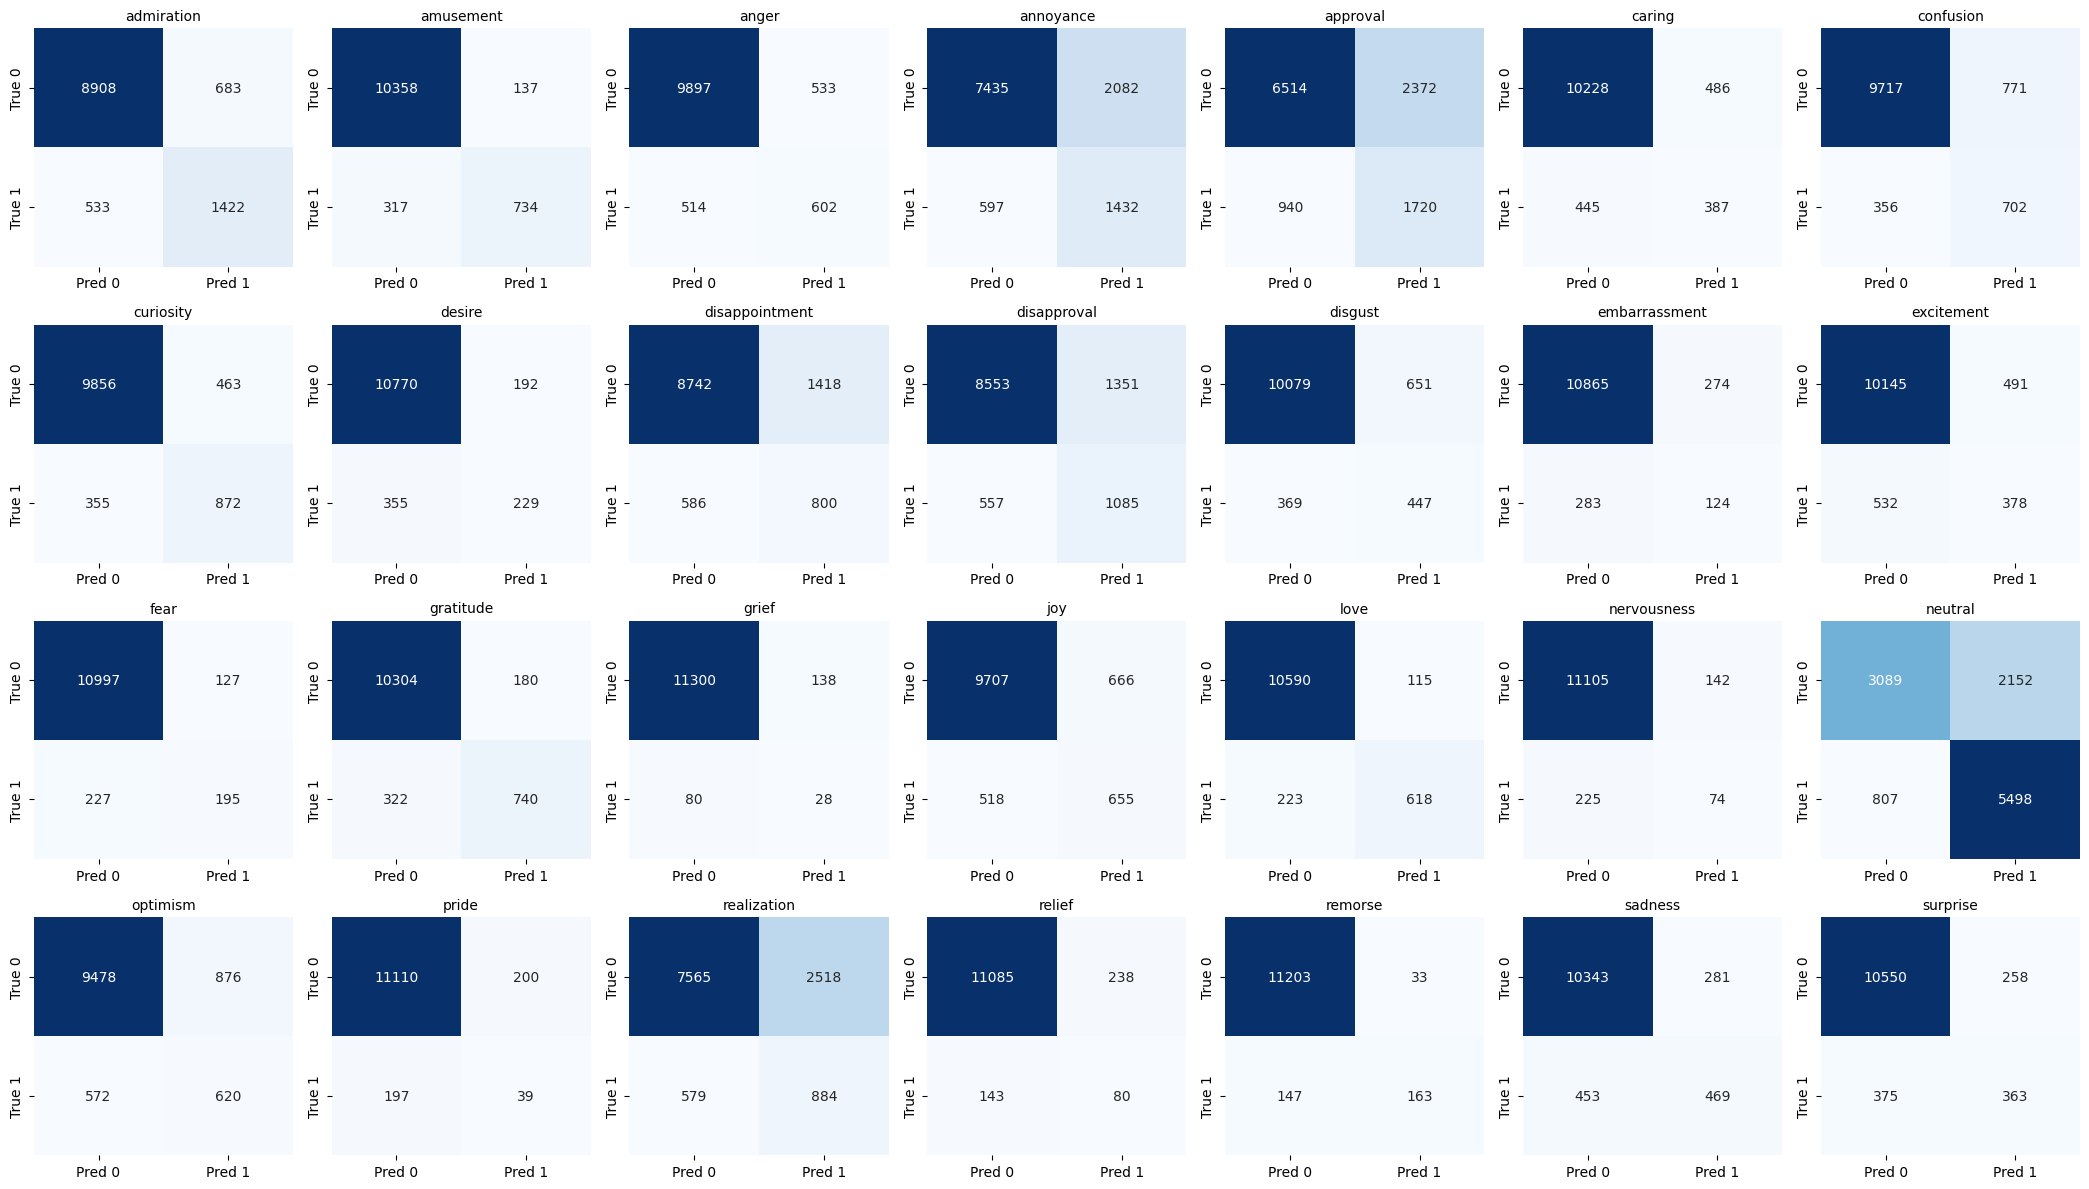

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Set up the grid
rows, cols = 4, 7
fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
axes = axes.flatten()

pred = trainer_best.predict(preprocessed_test_data)
logits = pred.predictions
labels = pred.label_ids

# Convert logits to probabilities using sigmoid
probs = torch.sigmoid(torch.tensor(logits)).numpy()

np.save("best_thresholds.npy", best_model_threshold)

try:
    best_thresholds = np.load("best_thresholds.npy")
    preds = (probs > best_thresholds).astype(int)
except FileNotFoundError:
    print("Best thresholds not found. Using default threshold of 0.5.")
    preds = (probs > 0.5).astype(int)


for i in range(len(label_cols)):
    cm = confusion_matrix(labels[:, i], preds[:, i], labels=[0, 1])

    # Handle edge case: only one class present
    if cm.shape != (2, 2):
        full_cm = np.zeros((2, 2), dtype=int)
        full_cm[:cm.shape[0], :cm.shape[1]] = cm
        cm = full_cm

    ax = axes[i]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Pred 0', 'Pred 1'], yticklabels=['True 0', 'True 1'], ax=ax)
    ax.set_title(label_cols[i], fontsize=10)
    ax.set_xlabel('')
    ax.set_ylabel('')

for j in range(len(label_cols), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

/tmp/ipython-input-20-1734769690.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_sorted, x='F1 Score', y='Label', palette='viridis')


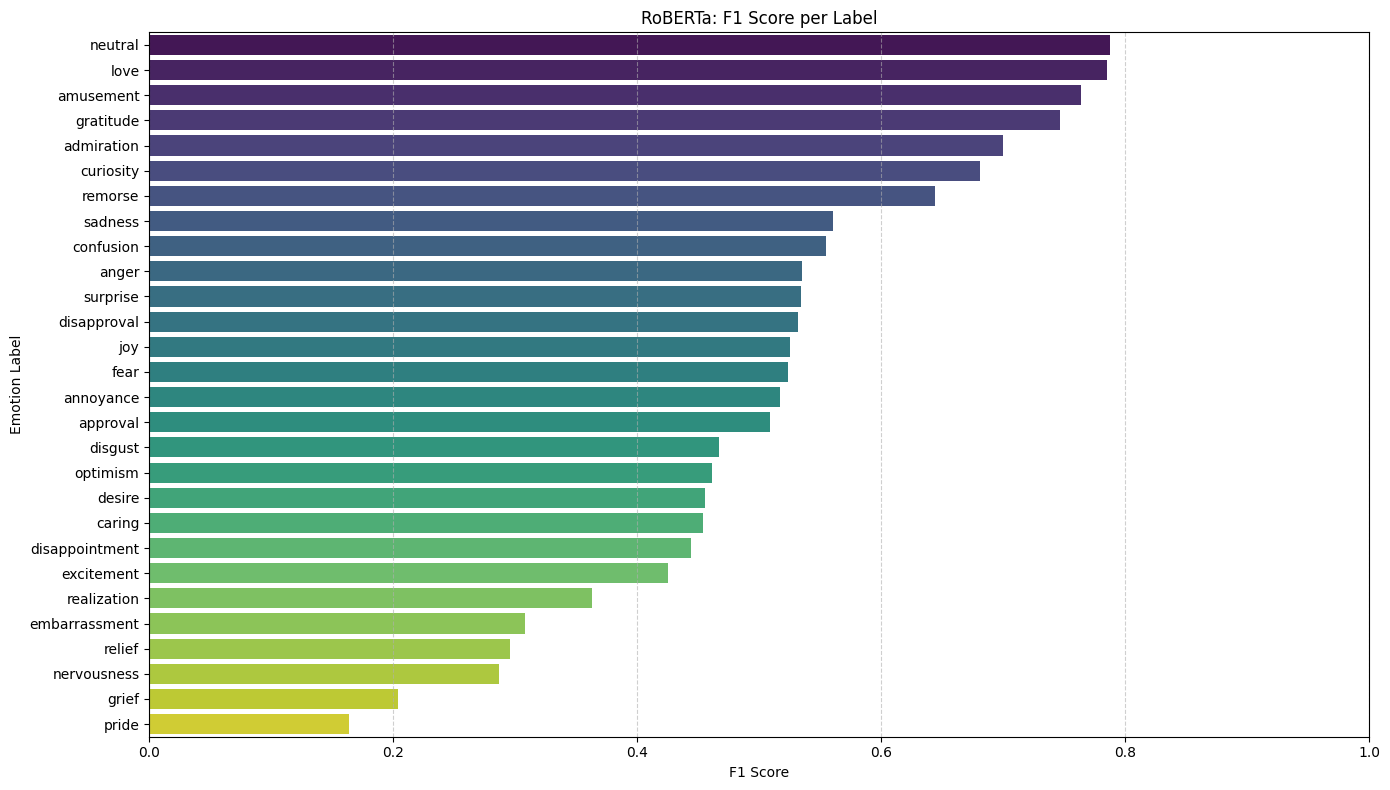

In [ ]:
# Sort by F1 score for better visualization
df_sorted = confusion_summary_df.sort_values(by='F1 Score', ascending=False)

# Set figure size
plt.figure(figsize=(14, 8))

# Plot F1 Score bar chart
sns.barplot(data=df_sorted, x='F1 Score', y='Label', palette='viridis')

plt.title('RoBERTa: F1 Score per Label')
plt.xlabel('F1 Score')
plt.ylabel('Emotion Label')
plt.xlim(0, 1)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

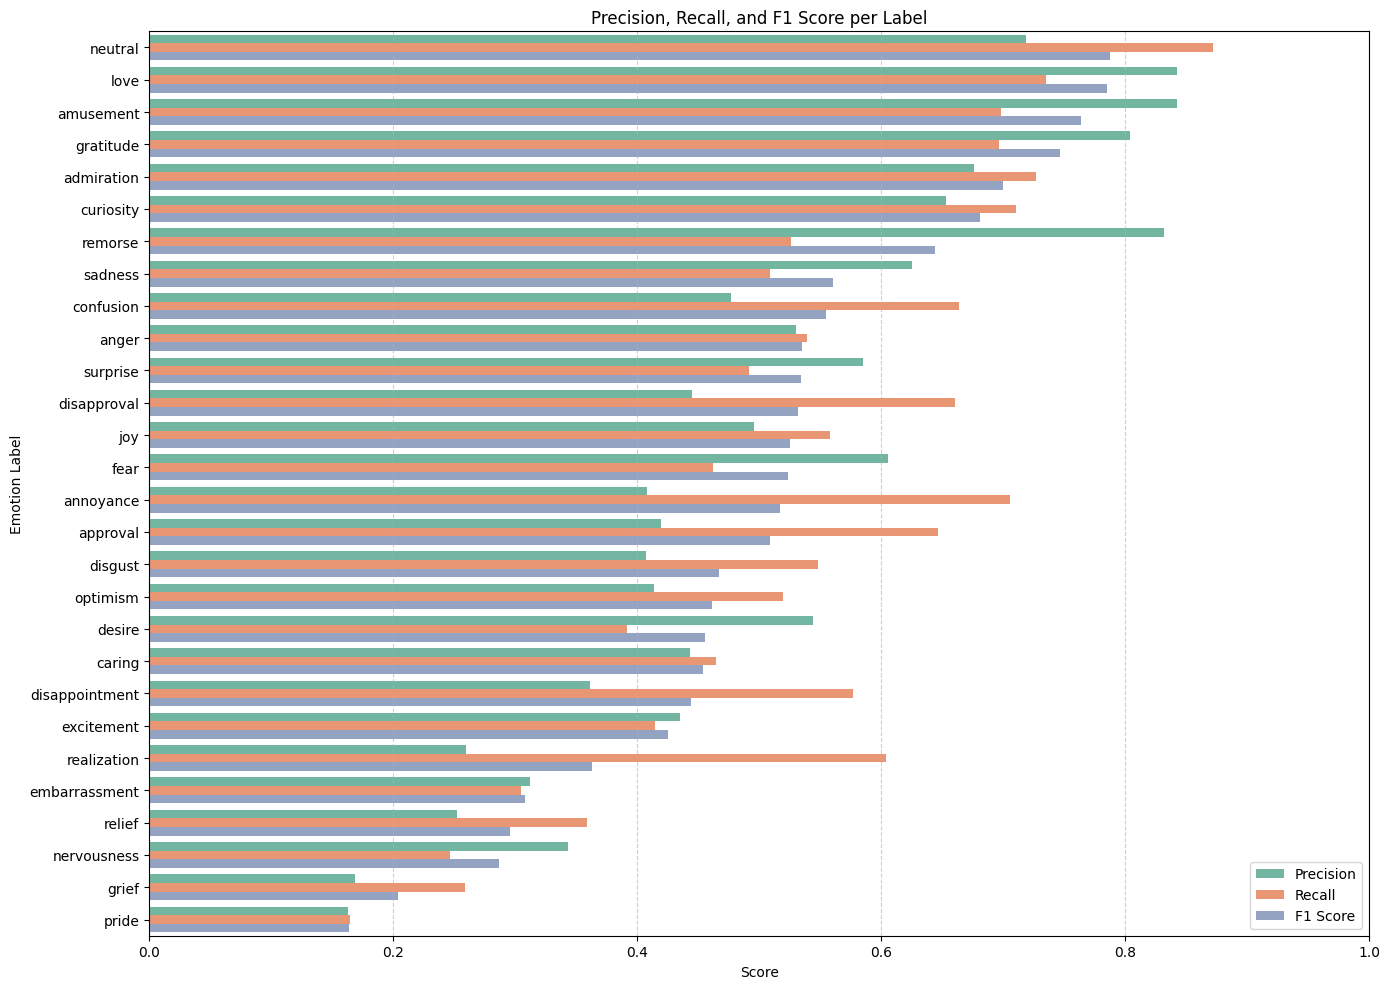

In [ ]:
# Melt the DataFrame to long format for Seaborn
metrics_df = df_sorted[['Label', 'Precision', 'Recall', 'F1 Score']].melt(id_vars='Label',
                                                                          var_name='Metric',
                                                                          value_name='Score')

plt.figure(figsize=(14, 10))
sns.barplot(data=metrics_df, x='Score', y='Label', hue='Metric', palette='Set2')

plt.title('Precision, Recall, and F1 Score per Label')
plt.xlabel('Score')
plt.ylabel('Emotion Label')
plt.xlim(0, 1)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

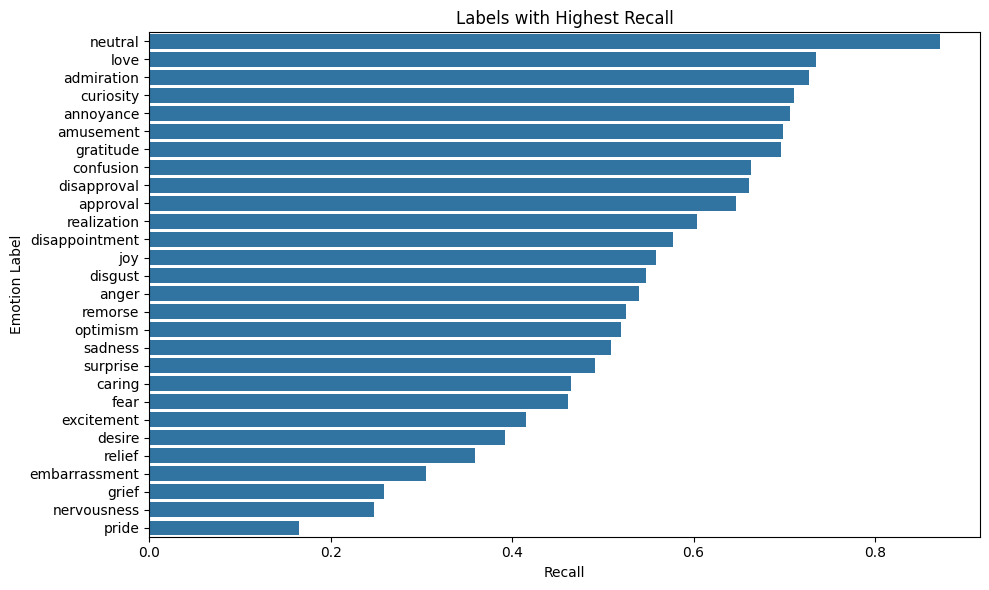

In [ ]:
from sklearn.metrics import precision_recall_fscore_support

# Calculate precision, recall, and F1 for each label
precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average=None)

# Put into a DataFrame
metric_df = pd.DataFrame({
    'Label': label_cols,
    'Precision': precision,
    'Recall': recall,
    'F1': f1
})

# Sort by Recall
top_recall = metric_df.sort_values(by='Recall', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Recall', y='Label', data=top_recall)
plt.title('Labels with Highest Recall')
plt.xlabel('Recall')
plt.ylabel('Emotion Label')
plt.tight_layout()
plt.show()


/tmp/ipython-input-24-1792998038.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_preds.values, y=top_preds.index, ax=ax, palette='Blues_r')
/tmp/ipython-input-24-1792998038.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_preds.values, y=top_preds.index, ax=ax, palette='Blues_r')
/tmp/ipython-input-24-1792998038.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_preds.values, y=top_preds.index, ax=ax, palette='Blues_r')
/tmp/ipython-input-24-1792998038.py:27: FutureWarning: 

Passing `palette` without assigning `

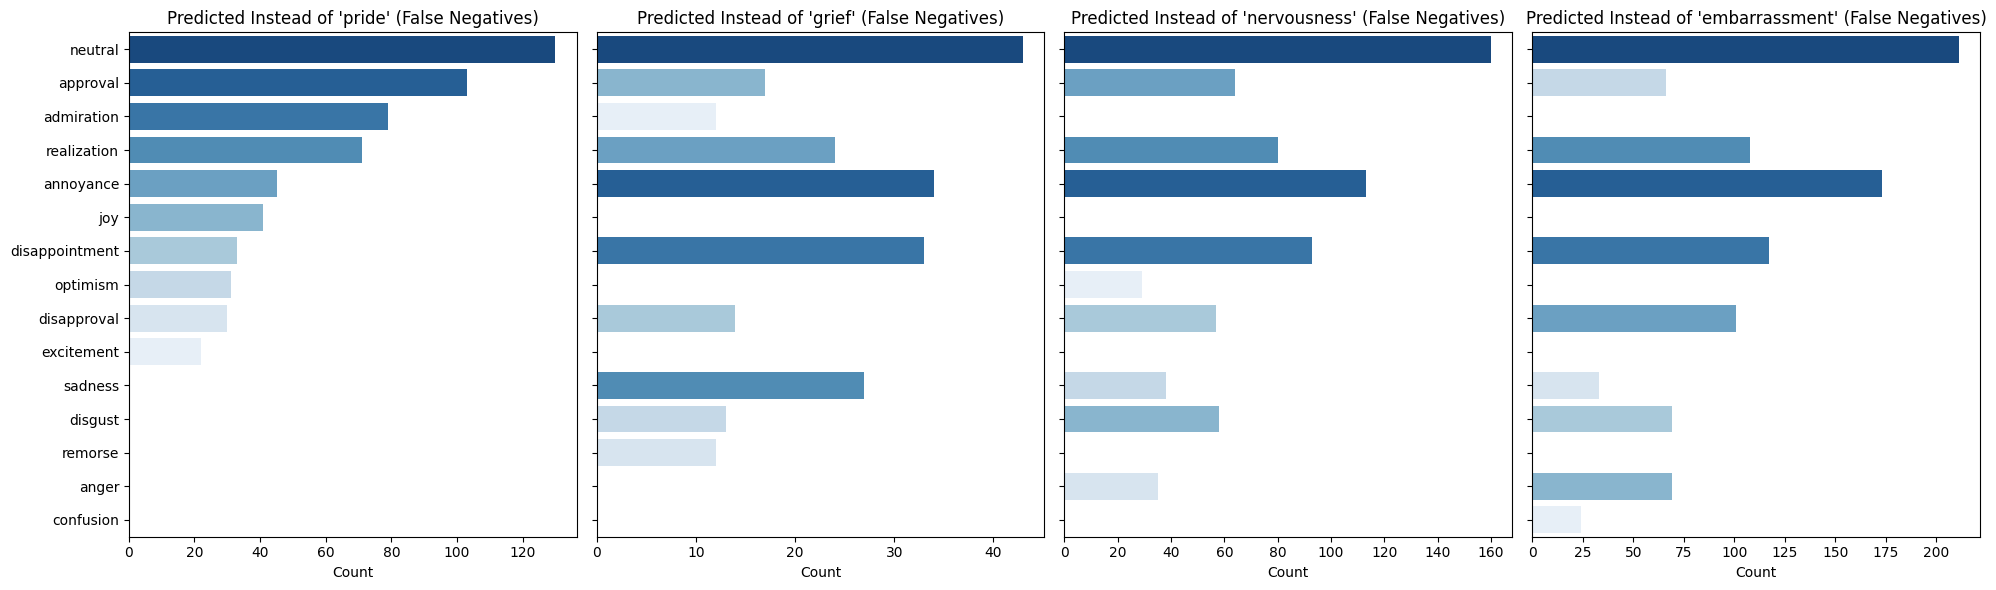

In [ ]:
# Labels to analyze
target_labels = ['pride','grief', 'nervousness','embarrassment']

# Convert to list if it's a Pandas Index
label_cols = list(label_cols)

# Store co-predicted label counts
co_predicted_counts = {}

for target in target_labels:
    idx = label_cols.index(target)

    fn_mask = (labels[:, idx] == 1) & (preds[:, idx] == 0)

    other_preds = preds[fn_mask]

    counts = np.sum(other_preds, axis=0)
    counts[idx] = 0
    co_predicted_counts[target] = pd.Series(counts, index=label_cols)


fig, axes = plt.subplots(1, 4, figsize=(20, 6), sharey=True)

for ax, target in zip(axes, target_labels):
    top_preds = co_predicted_counts[target].sort_values(ascending=False)[:10]

    sns.barplot(x=top_preds.values, y=top_preds.index, ax=ax, palette='Blues_r')
    ax.set_title(f"Predicted Instead of '{target}' (False Negatives)")
    ax.set_xlabel("Count")
    ax.set_ylabel("")

plt.tight_layout()
plt.show()


_________________________________________________________________________________________
# Training 6 Binary Models

Top 3 Labels  
* love
* gratitude
* amusement

Bottom 3 Labels
* relief
* pride
* grief

In [ ]:
## labels of interest

MAX_SEQUENCE_LENGTH = 35
target_labels = [ 'love', 'gratitude', 'amusement', 'relief', 'pride', 'grief']
roberta_model_trainer = {}

model_checkpoint_name = "roberta-base"
tokenizer = RobertaTokenizer.from_pretrained(model_checkpoint_name)

################################################################################
# Function to tokenize and extract binary label
def preprocess_binary_label(data, tokenizer, target_label):
    # Tokenize the 'text' data
    encoded = tokenizer.batch_encode_plus(
        data["text"],
        max_length=MAX_SEQUENCE_LENGTH,
        padding="max_length",
        truncation=True,
        return_attention_mask=True,
        return_token_type_ids=False,
    )

    # Convert the binary label to integer type
    encoded["labels"] = [int(x) for x in data[target_label]]  # Convert to integer for cross_entropy
    return encoded

################################################################################
# Function for computing metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    # logits has shape (batch_size, num_labels)
    preds = logits.argmax(axis=-1)   # shape (batch_size,), values in {0,1}

    return {
        "subset_accuracy": accuracy_score(labels, preds),
        "precision":        precision_score(labels, preds, average='binary', zero_division=0),
        "recall":           recall_score(labels, preds, average='binary', zero_division=0),
        "f1":               f1_score(labels, preds, average='binary', zero_division=0)
    }

################################################################################

# Train binary classifiers
for label in target_labels:

    roberta_model = RobertaForSequenceClassification.from_pretrained(model_checkpoint_name, num_labels=2, problem_type="single_label_classification")

    train_df = train_dataset.to_pandas()[['text', label]]
    val_df = val_dataset.to_pandas()[['text', label]]

    # Balance the training set (50% positive, 50% negative)
    train_pos = train_df[train_df[label] == 1]
    train_neg = train_df[train_df[label] == 0]

    if len(train_pos) < len(train_neg):
        train_neg = train_neg.sample(n=len(train_pos), random_state=42)
    else:
        train_pos = train_pos.sample(n=len(train_neg), random_state=42)

    train_balanced = pd.concat([train_pos, train_neg]).sample(frac=1, random_state=42)
    train_balanced_dataset = Dataset.from_pandas(train_balanced)
    val_dataset_filtered = Dataset.from_pandas(val_df)

    # Tokenize datasets
    train_encoded = train_balanced_dataset.map(
        lambda x: preprocess_binary_label(x, tokenizer, label), batched=True
    )
    val_encoded = val_dataset_filtered.map(
        lambda x: preprocess_binary_label(x, tokenizer, label), batched=True
    )

    # Training arguments
    training_args = TrainingArguments(
        output_dir=f"{label}_emotion_model",
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        num_train_epochs=2,
        eval_strategy="epoch",
        save_strategy="epoch",
        report_to="none",
        logging_strategy="epoch"
    )

    # Trainer
    trainer = Trainer(
        model=roberta_model,
        args=training_args,
        train_dataset=train_encoded,
        eval_dataset=val_encoded,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics
    )

    print(f"\nTraining binary classifier for '{label}'...\n")
    trainer.train()
    roberta_model_trainer[label] = trainer


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/5302 [00:00<?, ? examples/s]

Map:   0%|          | 0/11547 [00:00<?, ? examples/s]

/tmp/ipython-input-29-2517927653.py:85: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



Training binary classifier for 'love'...



Epoch,Training Loss,Validation Loss,Subset Accuracy,Precision,Recall,F1
1,0.402300,0.243731,0.939292,0.560918,0.829240,0.669184
2,0.278200,0.297438,0.919893,0.477273,0.859649,0.613779


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/6372 [00:00<?, ? examples/s]

Map:   0%|          | 0/11547 [00:00<?, ? examples/s]

/tmp/ipython-input-29-2517927653.py:85: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



Training binary classifier for 'gratitude'...



Epoch,Training Loss,Validation Loss,Subset Accuracy,Precision,Recall,F1
1,0.421200,0.272333,0.848878,0.363742,0.904808,0.518886
2,0.308800,0.317878,0.877284,0.415811,0.895192,0.567856


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/6186 [00:00<?, ? examples/s]

Map:   0%|          | 0/11547 [00:00<?, ? examples/s]

/tmp/ipython-input-29-2517927653.py:85: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



Training binary classifier for 'amusement'...



Epoch,Training Loss,Validation Loss,Subset Accuracy,Precision,Recall,F1
1,0.447800,0.349504,0.910280,0.500000,0.784749,0.610819
2,0.345600,0.350418,0.891487,0.442684,0.808880,0.572209


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/1292 [00:00<?, ? examples/s]

Map:   0%|          | 0/11547 [00:00<?, ? examples/s]

/tmp/ipython-input-29-2517927653.py:85: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



Training binary classifier for 'relief'...



Epoch,Training Loss,Validation Loss,Subset Accuracy,Precision,Recall,F1
1,0.629900,0.866147,0.762622,0.056239,0.740741,0.104541
2,0.394000,0.532100,0.839179,0.081591,0.740741,0.146991


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/1388 [00:00<?, ? examples/s]

Map:   0%|          | 0/11547 [00:00<?, ? examples/s]

/tmp/ipython-input-29-2517927653.py:85: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



Training binary classifier for 'pride'...



Epoch,Training Loss,Validation Loss,Subset Accuracy,Precision,Recall,F1
1,0.702600,0.642271,0.982939,0.000000,0.000000,0.000000
2,0.696200,0.703300,0.017061,0.017061,1.000000,0.033549


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/692 [00:00<?, ? examples/s]

Map:   0%|          | 0/11547 [00:00<?, ? examples/s]

/tmp/ipython-input-29-2517927653.py:85: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



Training binary classifier for 'grief'...



Epoch,Training Loss,Validation Loss,Subset Accuracy,Precision,Recall,F1
1,0.641600,0.695950,0.720187,0.023759,0.750000,0.046058
2,0.528600,0.527420,0.824716,0.035334,0.701923,0.067281


In [ ]:

summary_metrics = []
error_rates = []

for label in target_labels:
    # 1) Tokenize the test split for this label
    test_enc = test_dataset.map(
        lambda x: preprocess_binary_label(x, tokenizer, label),
        batched=True
    )

    # 2) Predict
    logits, label_ids, _ = roberta_model_trainer[label].predict(test_enc)
    preds = logits.argmax(axis=-1)

    # 3) Performance summary
    acc  = accuracy_score(label_ids, preds)
    prec = precision_score(label_ids, preds, zero_division=0)
    rec  = recall_score(label_ids, preds, zero_division=0)
    f1   = f1_score(label_ids, preds, zero_division=0)

    summary_metrics.append({
        'label':    label,
        'accuracy':  acc,
        'precision': prec,
        'recall':    rec,
        'f1_score':  f1
    })

    # 4) Confusion matrix rates
    tn, fp, fn, tp = confusion_matrix(label_ids, preds).ravel()
    tnr = tn / (tn + fp) if (tn + fp) > 0 else 0
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0  # True Positive Rate

    error_rates.append({
        'label':                   label,
        'true_negative_rate':      tnr,
        'false_positive_rate':     fpr,
        'false_negative_rate':     fnr,
        'true_positive_rate':      tpr,
    })

# 5) Build DataFrames
df_summary     = pd.DataFrame(summary_metrics)
df_error_rates = pd.DataFrame(error_rates)

# 6) Display or save
print("=== Performance Summary ===")
print(df_summary.to_string(index=False))
print("\n=== Error Rates ===")
print(df_error_rates.to_string(index=False))


Map:   0%|          | 0/11546 [00:00<?, ? examples/s]

Map:   0%|          | 0/11546 [00:00<?, ? examples/s]

Map:   0%|          | 0/11546 [00:00<?, ? examples/s]

Map:   0%|          | 0/11546 [00:00<?, ? examples/s]

Map:   0%|          | 0/11546 [00:00<?, ? examples/s]

Map:   0%|          | 0/11546 [00:00<?, ? examples/s]

=== Performance Summary ===
    label  accuracy  precision   recall  f1_score
     love  0.917028   0.463460 0.882283  0.607699
gratitude  0.877447   0.420958 0.885122  0.570561
amusement  0.887927   0.437144 0.803996  0.566354
   relief  0.840637   0.085597 0.748879  0.153634
    pride  0.020440   0.020440 1.000000  0.040061
    grief  0.833362   0.044634 0.824074  0.084681

=== Error Rates ===
    label  true_negative_rate  false_positive_rate  false_negative_rate  true_positive_rate
     love            0.919757             0.080243             0.117717            0.882283
gratitude            0.876669             0.123331             0.114878            0.885122
amusement            0.896332             0.103668             0.196004            0.803996
   relief            0.842445             0.157555             0.251121            0.748879
    pride            0.000000             1.000000             0.000000            1.000000
    grief            0.833450             0.16655

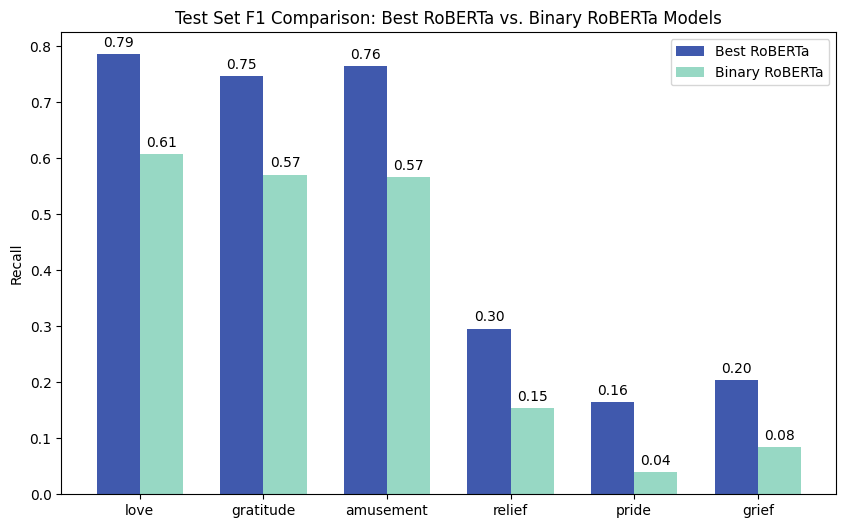

In [3]:
target_labels = [ 'love', 'gratitude', 'amusement', 'relief', 'pride', 'grief']
# Best RoBERTa model F1 results from test set: weights, thresholds, freezing
roberta_best_model = [ 0.785260 ,  0.746720,   0.763788,  0.295749 ,  0.164211,  0.204380 ]
# RoBERTa binary results from test set
binary_roberta = [0.607699,0.570561, 0.566354,0.153634,0.040061,0.084681]

# creating bar graph
x= np.arange(len(target_labels))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, roberta_best_model, width, label='Best RoBERTa',color='#4059AD')
rects2 = ax.bar(x + width/2, binary_roberta, width, label='Binary RoBERTa', color='#97D8C4')

ax.set_ylabel('F1')
ax.set_title('Test Set F1 Comparison: Best RoBERTa vs. Binary RoBERTa Models')
ax.set_xticks(x)
ax.set_xticklabels(target_labels)
ax.legend()

ax.bar_label(rects1, fmt='%.2f', padding=3)
ax.bar_label(rects2, fmt='%.2f', padding=3)

plt.show()

